# LSTM Tutorial || Rachiketa

## import library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read dataset

In [ ]:
df = pd.read_csv('/content/monthly_milk_production.csv',index_col='Date',parse_dates=True)
#df = pd.read_csv('/content/monthly_milk_production.csv')

df.index.freq='MS'

In [ ]:
df

Production
Date                  
1962-01-01         589
1962-02-01         561
1962-03-01         640
1962-04-01         656
1962-05-01         727
...                ...
1975-08-01         858
1975-09-01         817
1975-10-01         827
1975-11-01         797
1975-12-01         843

[168 rows x 1 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


In [ ]:
df.columns

Index(['Production'], dtype='object')

In [ ]:
df.describe()

Production
count  168.000000
mean   754.708333
std    102.204524
min    553.000000
25%    677.750000
50%    761.000000
75%    824.500000
max    969.000000

## see data pattern

<Axes: xlabel='Date'>

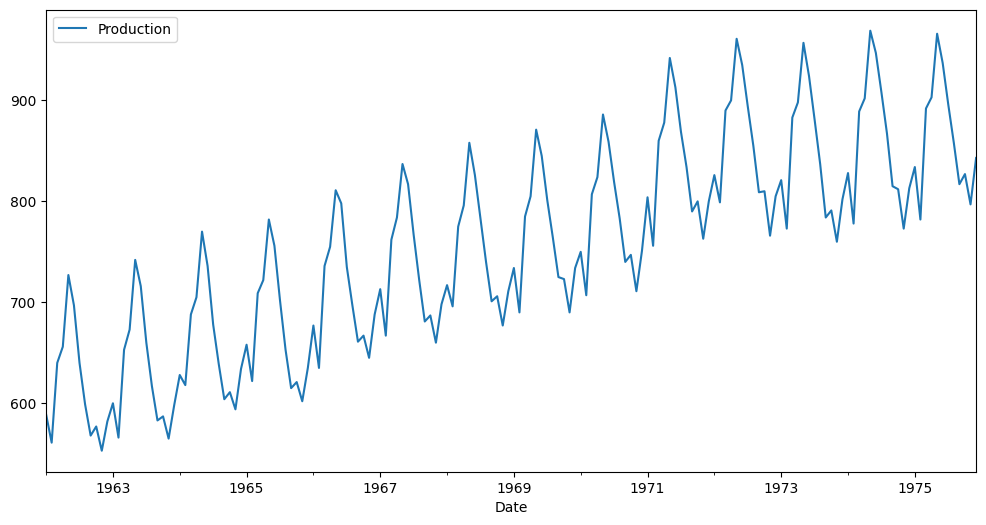

In [ ]:
df.plot(figsize=(12,6)) # The value figsize=(12,6) represents the width and height of the plot in inches.

To view different component (like seasonal nature, trend) we use stats model

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

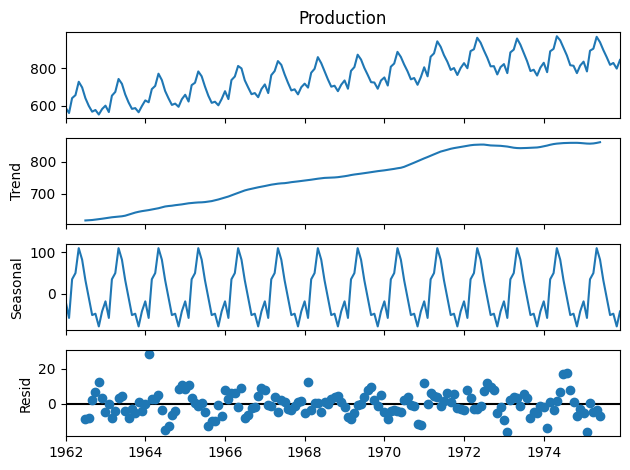

In [ ]:
results = seasonal_decompose(df['Production'])
results.plot();

In [ ]:
len(df)

168

## Split the dataset

In [ ]:
train = df.iloc[:156]
test = df.iloc[156:]


Now we are going to preprocess the data. we will uce min max scaler to convert the data into scale of zero to one


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
'''
scaler.fit(train): This line computes the mean and standard deviation for scaling using the train dataset.
The fit method calculates these statistics, which are stored in the scaler object.

scaled_train = scaler.transform(train): This line applies the scaling transformation to the train dataset.
The transform method uses the previously computed mean and standard deviation to scale the data.
'''
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
#Lets see the scaled data
scaled_train[:10]
print(scaled_train.shape)

(156, 1)


The `TimeseriesGenerator` class from the keras.preprocessing.sequence module in TensorFlow's Keras API is a powerful tool for generating batches of temporal data for time series forecasting tasks. It allows you to efficiently create sequences and their corresponding targets, which is especially useful for training recurrent neural networks (RNNs) like LSTM or GRU models.

In [ ]:
# from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

scaled_train (First Argument):
- This is the input data.
It's your scaled time series data, typically in the shape (samples, features).

scaled_train (Second Argument):
- This is the target data (what you want the model to predict).
In this case, you're using the same time series data for both input and target, which is typical for time series forecasting.

length=n_input:
- Determines how many time steps to include in each input sequence.
Here, n_input = 3, so the model will take 3 time steps as input to predict the next step.

batch_size=1:
- Specifies the number of samples per batch.
With batch_size=1, each batch will contain 1 sequence of length n_input.

In [ ]:
# define generator
''''
data=scaled_train: The input data to generate sequences from.
targets=scaled_train: The target data corresponding to the input sequences.
In this case, it's the same as the input data because you're preparing the data for a forecasting task.
'''
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

When you access an element of the generator using an index (e.g., generator[0]), it returns a tuple consisting of the input sequence and the target value for that batch.

In [ ]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [ ]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

## make LSTM model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [ ]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0056 - loss: 0.1220
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0019 - loss: 0.0247
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0070 - loss: 0.0228
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0226 - loss: 0.0145
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0028 - loss: 0.0145
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0095 - loss: 0.0087
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0013 - loss: 0.0089    
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0063 - loss: 0.0057
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0038 - loss: 0.0063
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0029 - loss: 0.0102
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0150 - loss: 0.0152
Epoch 12/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

``History Object``
The History object has a member called history, which is a dictionary. This dictionary stores the values of the loss and any other metrics specified during the model compilation for each epoch.

model.history.history['loss']: The list of loss values recorded at the end of each epoch

In [ ]:
loss_per_epoch = model.history.history['loss']
len(loss_per_epoch)

50

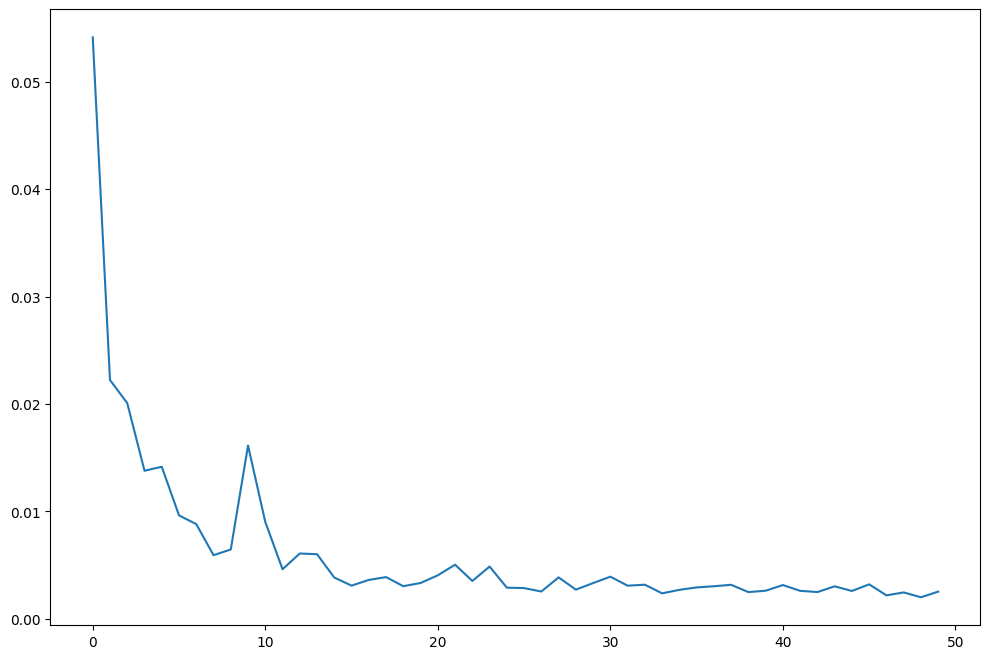

In [ ]:
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
#[-12:]: This is Python's slicing syntax. It means "take the last 12 elements from the list."
last_train_batch = scaled_train[-12:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
print("Reshaped last_train_batch:")
print(last_train_batch)
print("Shape of last_train_batch:", last_train_batch.shape)

Reshaped last_train_batch:
[[[0.66105769]
  [0.54086538]
  [0.80769231]
  [0.83894231]
  [1.        ]
  [0.94711538]
  [0.85336538]
  [0.75480769]
  [0.62980769]
  [0.62259615]
  [0.52884615]
  [0.625     ]]]
Shape of last_train_batch: (1, 12, 1)


## Make prediction

In [ ]:
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


array([[0.59215206]], dtype=float32)

In [ ]:
#Check with the real value
scaled_test[0]

array([0.67548077])

current_pred = model.predict(current_batch)[0]:

- Predict the next time step using the current batch.
[0] extracts the predicted value from the model's output.

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [ ]:
test_predictions

[array([0.59215206], dtype=float32),
 array([0.57755643], dtype=float32),
 array([0.738116], dtype=float32),
 array([0.81474376], dtype=float32),
 array([0.9250695], dtype=float32),
 array([0.9097178], dtype=float32),
 array([0.8374923], dtype=float32),
 array([0.73316985], dtype=float32),
 array([0.6218627], dtype=float32),
 array([0.579348], dtype=float32),
 array([0.53344125], dtype=float32),
 array([0.5604319], dtype=float32)]

In [ ]:
test.head()

Production
Date                  
1975-01-01         834
1975-02-01         782
1975-03-01         892
1975-04-01         903
1975-05-01         966

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
# Add a new column Predictions to the test DataFrame and set it to true_predictions
test['Predictions'] = true_predictions

<Axes: xlabel='Date'>

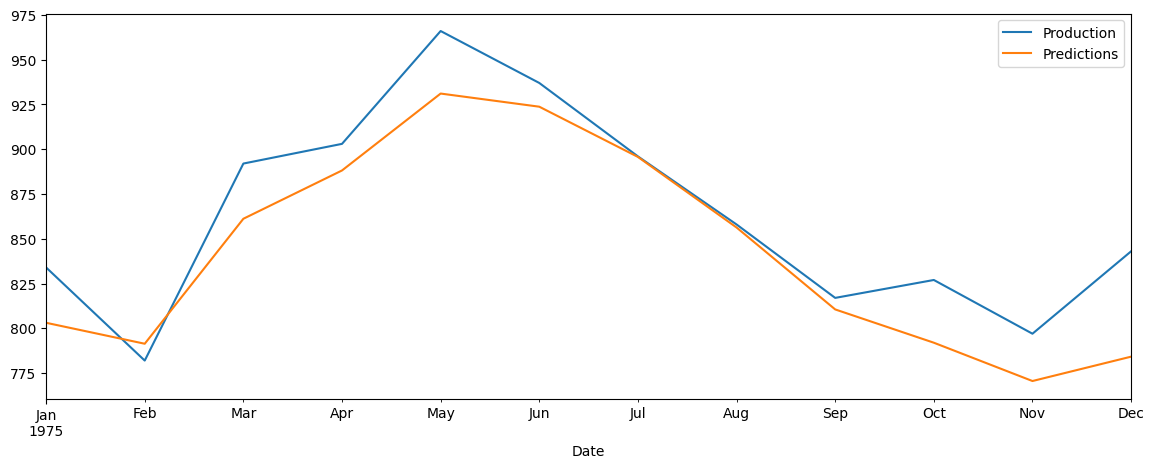

In [ ]:
test.plot(figsize=(14,5))

## Evaluate

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

26.080904949190113


# Auto Regression (AR) || Rachiketa

## import library

In [ ]:
!pip install statsmodels --upgrade
import pandas as pd
import numpy as np
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg

## Read data

In [ ]:
df=pd.read_csv('/content/MaunaLoaDailyTemps.csv',index_col='DATE'   ,parse_dates=True)
df=df.dropna()
print('Shape of data',df.shape)
df.head()

Shape of data (1821, 5)


MinTemp  MaxTemp  AvgTemp  Sunrise  Sunset
DATE                                                  
2014-01-01     33.0     46.0     40.0      657    1756
2014-01-02     35.0     50.0     43.0      657    1756
2014-01-03     36.0     45.0     41.0      657    1757
2014-01-04     32.0     41.0     37.0      658    1757
2014-01-05     24.0     38.0     31.0      658    1758

## Plot Your Data

<Axes: xlabel='DATE'>

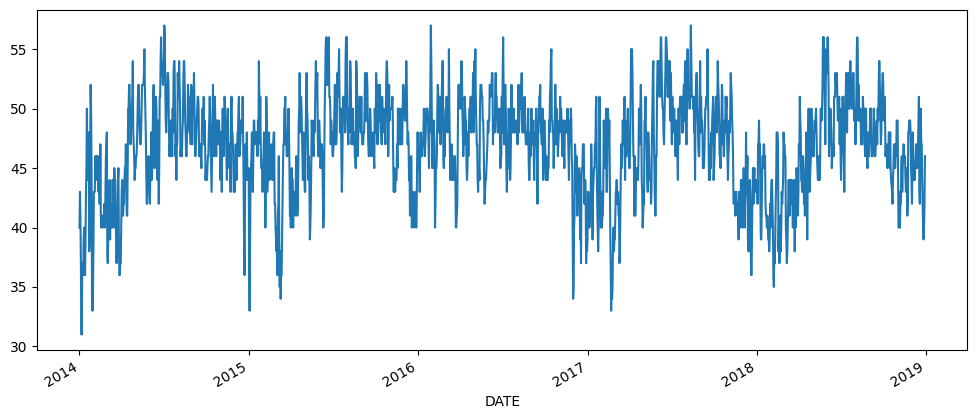

In [ ]:
df['AvgTemp'].plot(figsize=(12,5))

## Check For Stationarity

`Augmented Dickey-Fuller (ADF) test`, a statistical test used to check whether a time series is stationary (i.e., its properties like mean and variance do not change over time).

adfuller(dataset, autolag='AIC'): This function runs the Augmented Dickey-Fuller test on the input dataset.
- autolag='AIC': Automatically selects the number of lags based on the `Akaike Information Criterion (AIC)`.

dftest Output Explanation:
- dftest[0] (ADF Statistic): A test statistic to determine stationarity.
If the statistic is less than the critical value, the series is stationary.

- dftest[1] (P-Value): Tests the null hypothesis (series has a unit root, i.e., is non-stationary).
A low p-value (< 0.05) suggests rejecting the null hypothesis (series is stationary).
- dftest[2] (Num of Lags): Optimal number of lags used in the test.
- dftest[3] (Num of Observations): Number of observations used in the regression.
- dftest[4] (Critical Values): Critical values for different confidence levels (1%, 5%, 10%). Used to compare with the ADF statistic.


In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [ ]:
adf_test(df['AvgTemp'])

1. ADF :  -6.554680125068777
2. P-Value :  8.675937480199653e-09
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1808
5. Critical Values :
	 1% :  -3.433972018026501
	 5% :  -2.8631399192826676
	 10% :  -2.5676217442756872


how many past values should we consider? for that we will do ACF PACF test

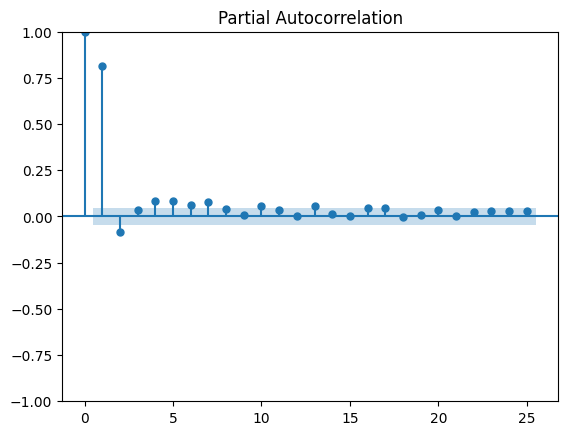

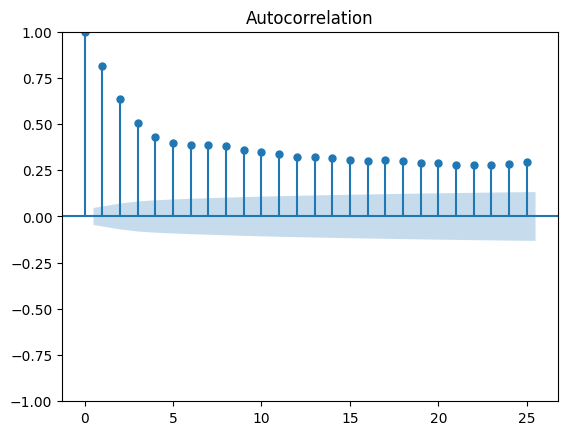

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
pacf = plot_pacf(df['AvgTemp'],lags=25)
acf = plot_acf(df['AvgTemp'],lags=25)

# ARIMA Model || Rachiketa



## import Library

In [ ]:
!pip install pmdarima
import pandas as pd
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.0 MB/s eta 0:00:00


## Read Data

In [ ]:
df=pd.read_csv('/content/MaunaLoaDailyTemps.csv',index_col='DATE',parse_dates=True)
df=df.dropna()
print('Shape of data',df.shape)
df.head()

Shape of data (1821, 5)


MinTemp  MaxTemp  AvgTemp  Sunrise  Sunset
DATE                                                  
2014-01-01     33.0     46.0     40.0      657    1756
2014-01-02     35.0     50.0     43.0      657    1756
2014-01-03     36.0     45.0     41.0      657    1757
2014-01-04     32.0     41.0     37.0      658    1757
2014-01-05     24.0     38.0     31.0      658    1758

## Plot your Data

<Axes: xlabel='DATE'>

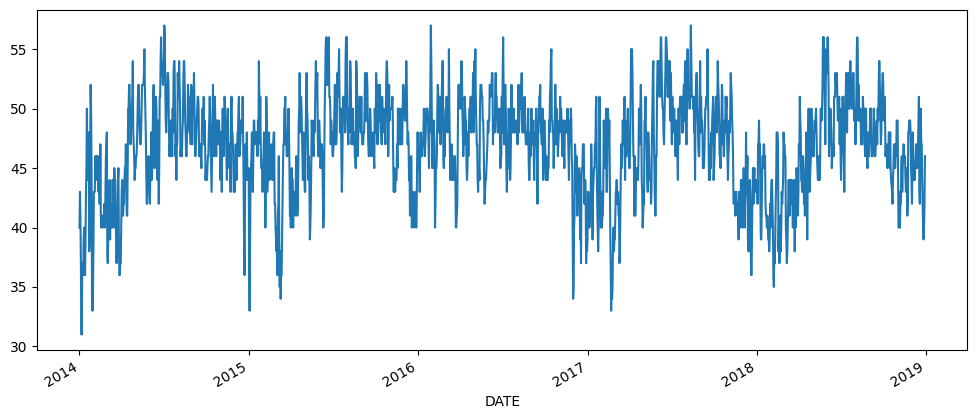

In [ ]:
df['AvgTemp'].plot(figsize=(12,5))

## Check for Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

adf_test(df['AvgTemp'])

1. ADF :  -6.554680125068784
2. P-Value :  8.675937480199322e-09
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1808
5. Critical Values :
	 1% :  -3.433972018026501
	 5% :  -2.8631399192826676
	 10% :  -2.5676217442756872


## Find the order of ARIMA model

`from pmdarima import auto_arima:`
- auto_arima is a function from the pmdarima library that automatically determines the best ARIMA (AutoRegressive Integrated Moving Average) model for a given time series dataset.
- auto_arima will try different combination of orders and for every combo it will assign a score, AIC. The goal is to minimize AIC

`Why Suppress Warnings?`
Time series modeling often involves iterative optimization and statistical calculations, which can generate warnings that do not affect the final outcome (e.g., convergence messages, deprecated functionality).
Suppressing warnings keeps the output cleaner, making it easier to focus on the key results like model parameters and evaluation metrics
'''

In [ ]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
stepwise_fit = auto_arima(df['AvgTemp'],
                          suppress_warnings=True)

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1821
Model:               SARIMAX(1, 0, 5)   Log Likelihood               -4139.876
Date:                Wed, 15 Jan 2025   AIC                           8295.753
Time:                        09:21:23   BIC                           8339.810
Sample:                             0   HQIC                          8312.007
                               - 1821                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3542      0.395      3.432      0.001       0.581       2.128
ar.L1          0.9709      0.008    114.291      0.000       0.954       0.988
ma.L1         -0.1244      0.024     -5.190      0.000      -0.171      -0.077
ma.L2         -0.2209      0.024     -9.047      0.000      -0.269      -0.173
ma.L3         -0.2033      0.024     -8.416      0.000      -0.251      -0.156
ma.L4         -0.1316      0.023     -5.744      0.000      -0.177      -0.087
ma.L5         -0.0472      0.024     -1.929      0.054      -0.095       0.001
sigma2         5.5106      0.173     31.873      0.000       5.172       5.849
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                21.50
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

so, the optimal order has found SARIMA(1,0,5). SARIMA is a kind of ARIMA model with seasonality

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

## Split Data into Training and Testing
The last line of your code, print(test.iloc[0], test.iloc[-1]), is used to display the first and last rows of the test dataset. Here's what it does:

In [ ]:
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(1821, 5)
(1791, 5) (30, 5)
MinTemp      36.0
MaxTemp      52.0
AvgTemp      44.0
Sunrise     640.0
Sunset     1743.0
Name: 2018-12-01 00:00:00, dtype: float64 MinTemp      39.0
MaxTemp      52.0
AvgTemp      46.0
Sunrise     656.0
Sunset     1754.0
Name: 2018-12-30 00:00:00, dtype: float64


In [ ]:
print(train)

            MinTemp  MaxTemp  AvgTemp  Sunrise  Sunset
DATE                                                  
2014-01-01     33.0     46.0     40.0      657    1756
2014-01-02     35.0     50.0     43.0      657    1756
2014-01-03     36.0     45.0     41.0      657    1757
2014-01-04     32.0     41.0     37.0      658    1757
2014-01-05     24.0     38.0     31.0      658    1758
...             ...      ...      ...      ...     ...
2018-11-26     41.0     56.0     49.0      637    1742
2018-11-27     40.0     57.0     49.0      638    1742
2018-11-28     42.0     56.0     49.0      638    1742
2018-11-29     38.0     57.0     48.0      639    1742
2018-11-30     38.0     52.0     45.0      640    1742

[1791 rows x 5 columns]


## Train the Model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Define and fit the model
model = ARIMA(train['AvgTemp'], order=(1, 0, 5))
model = model.fit()

# Summary of the model
# print(result.summary())
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                AvgTemp   No. Observations:                 1791
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -4070.198
Date:                Sat, 14 Dec 2024   AIC                           8156.395
Time:                        15:17:02   BIC                           8200.320
Sample:                             0   HQIC                          8172.614
                               - 1791                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.5856      0.758     61.454      0.000      45.100      48.071
ar.L1          0.9856      0.005    188.230      0.000       0.975       0.996
ma.L1         -0.1412      0.023     -6.124      0.000      -0.186      -0.096
ma.L2         -0.2268      0.024     -9.635      0.000      -0.273      -0.181
ma.L3         -0.2168      0.023     -9.251      0.000      -0.263      -0.171
ma.L4         -0.1479      0.023     -6.491      0.000      -0.193      -0.103
ma.L5         -0.0595      0.024     -2.438      0.015      -0.107      -0.012
sigma2         5.5093      0.174     31.624      0.000       5.168       5.851
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.88
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Make Predictions on Test Set

2018-12-01    44.754109
2018-12-02    44.987795
2018-12-03    45.388741
2018-12-04    45.721546
2018-12-05    45.863733
2018-12-06    45.874126
2018-12-07    45.884370
2018-12-08    45.894466
2018-12-09    45.904417
2018-12-10    45.914225
2018-12-11    45.923891
2018-12-12    45.933419
2018-12-13    45.942809
2018-12-14    45.952064
2018-12-15    45.961185
2018-12-16    45.970176
2018-12-17    45.979036
2018-12-18    45.987770
2018-12-19    45.996377
2018-12-20    46.004861
2018-12-21    46.013222
2018-12-22    46.021464
2018-12-23    46.029586
2018-12-24    46.037591
2018-12-25    46.045482
2018-12-26    46.053258
2018-12-27    46.060923
2018-12-28    46.068477
2018-12-29    46.075923
2018-12-30    46.083261
Freq: D, Name: ARIMA predictions, dtype: float64


<Axes: xlabel='DATE'>

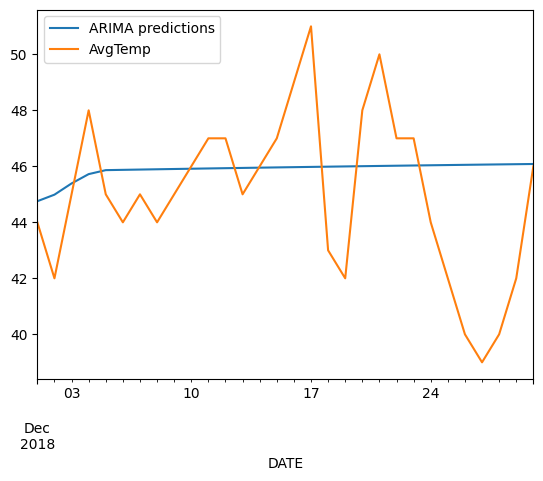

In [ ]:
start=len(train)
end=len(train)+len(test)-1
#if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
index_future_dates=pd.date_range(start='2018-12-01',end='2018-12-30')

pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred.index=index_future_dates
print(pred)
pred.plot(legend=True)
test['AvgTemp'].plot(legend=True)

Key Difference:
1. LSTMs: Require you to explicitly pass past values as input since they're designed for sequence learning.
2. ARIMA/VAR: Automatically use past values from their fitted internal memory, so you only need to specify the forecast range.


<Axes: xlabel='DATE'>

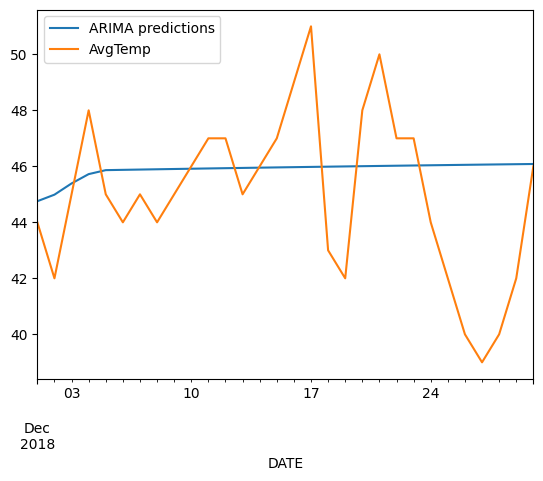

In [ ]:
pred.plot(legend='ARIMA Predictions')
test['AvgTemp'].plot(legend=True)

## Evaluation

In [ ]:
test['AvgTemp'].mean()

45.0

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['AvgTemp']))
print(rmse)


3.000463935942664


## make prediction for future values

this time we will retrain the entire dataset

In [ ]:
model2=ARIMA(df['AvgTemp'],order=(1,0,5))
model2=model2.fit()
df.tail()

MinTemp  MaxTemp  AvgTemp  Sunrise  Sunset
DATE                                                  
2018-12-26     35.0     45.0     40.0      654    1752
2018-12-27     33.0     44.0     39.0      655    1752
2018-12-28     33.0     47.0     40.0      655    1753
2018-12-29     36.0     47.0     42.0      655    1753
2018-12-30     39.0     52.0     46.0      656    1754

In [ ]:
index_future_dates=pd.date_range(start='2018-12-30',end='2019-01-29')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+30,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)

2018-12-30    46.418166
2018-12-31    46.113912
2019-01-01    45.617874
2019-01-02    45.249566
2019-01-03    45.116915
2019-01-04    45.136666
2019-01-05    45.156140
2019-01-06    45.175341
2019-01-07    45.194274
2019-01-08    45.212942
2019-01-09    45.231349
2019-01-10    45.249498
2019-01-11    45.267393
2019-01-12    45.285038
2019-01-13    45.302436
2019-01-14    45.319591
2019-01-15    45.336505
2019-01-16    45.353183
2019-01-17    45.369628
2019-01-18    45.385842
2019-01-19    45.401829
2019-01-20    45.417593
2019-01-21    45.433137
2019-01-22    45.448462
2019-01-23    45.463574
2019-01-24    45.478474
2019-01-25    45.493165
2019-01-26    45.507651
2019-01-27    45.521934
2019-01-28    45.536017
2019-01-29    45.549903
Freq: D, Name: ARIMA Predictions, dtype: float64


<Axes: >

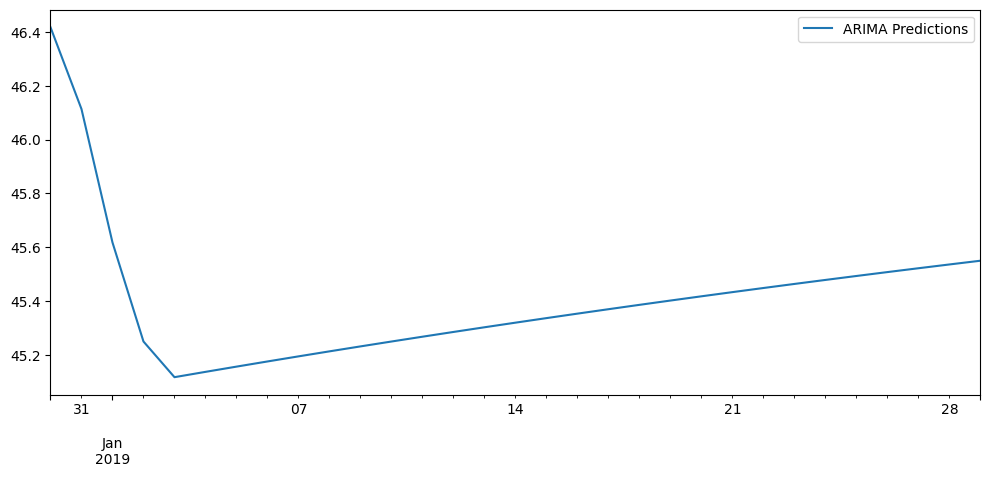

In [ ]:
pred.plot(figsize=(12,5),legend=True)

# Time Series Linear Regresssion & Random Forest | Rachiketa

Here we will see how to manipulate dataset to fit any ML models



## Import Library

What is df.index.freq?
- When working with time series data, the index of your DataFrame often consists of datetime objects. However, just having a datetime index doesn’t automatically tell pandas about the regularity (or frequency) of the data.
- df.index.freq refers to the frequency of your time series index.
By setting df.index.freq = 'MS', you tell pandas that the data occurs monthly, specifically at the start of each month.

Frequency Codes
- 'MS': Month Start (e.g., '2023-01-01', '2023-02-01').
- 'M': Month End (e.g., '2023-01-31', '2023-02-28').
- 'D': Daily.
- 'H': Hourly.
- 'Q': Quarterly End.
- 'A': Yearly End.

In [ ]:
import pandas as pd
df=pd.DataFrame()

## Read data

In [ ]:
df = pd.read_csv('/content/Alcohol_Sales.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [ ]:
df.tail()

Sales
DATE             
2018-09-01  12396
2018-10-01  13914
2018-11-01  14174
2018-12-01  15504
2019-01-01  10718

<Axes: xlabel='DATE'>

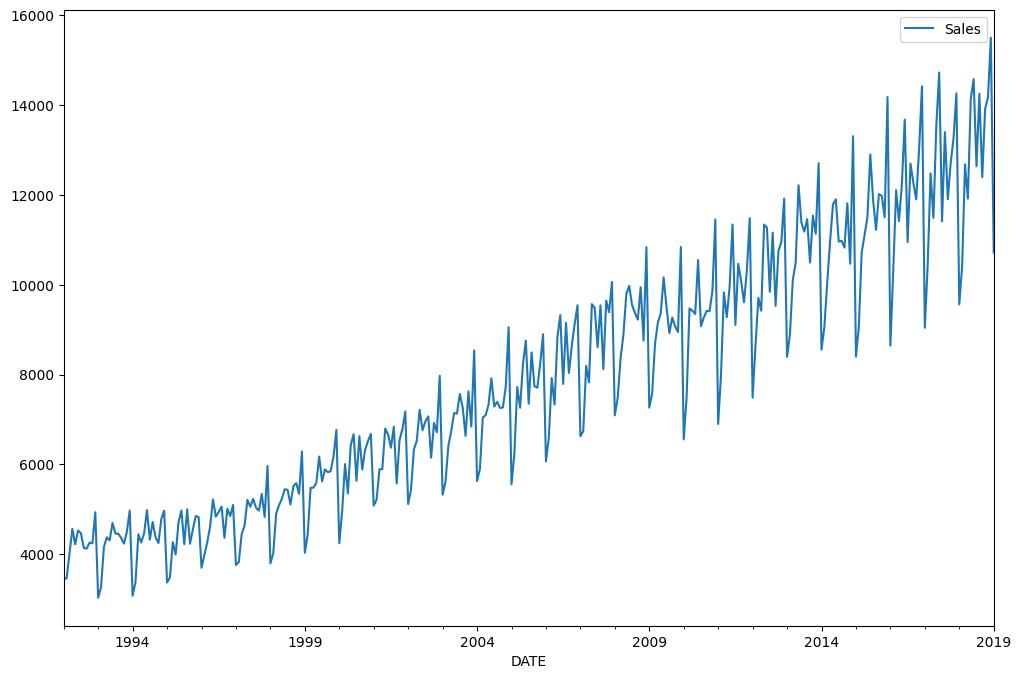

In [ ]:
df.columns = ['Sales']
df.plot(figsize=(12,8))

## Shifting Data

df['Sales'].shift(+1):
- Shifts the Sales column one month backward.
The new column Sale_LastMonth will contain the sales data from the previous month for each row.

In [ ]:
df['Sale_LastMonth']=df['Sales'].shift(+1)
df['Sale_2Monthsback']=df['Sales'].shift(+2)
df['Sale_3Monthsback']=df['Sales'].shift(+3)
df

Sales  Sale_LastMonth  Sale_2Monthsback  Sale_3Monthsback
DATE                                                                 
1992-01-01   3459             NaN               NaN               NaN
1992-02-01   3458          3459.0               NaN               NaN
1992-03-01   4002          3458.0            3459.0               NaN
1992-04-01   4564          4002.0            3458.0            3459.0
1992-05-01   4221          4564.0            4002.0            3458.0
...           ...             ...               ...               ...
2018-09-01  12396         14257.0           12640.0           14583.0
2018-10-01  13914         12396.0           14257.0           12640.0
2018-11-01  14174         13914.0           12396.0           14257.0
2018-12-01  15504         14174.0           13914.0           12396.0
2019-01-01  10718         15504.0           14174.0           13914.0

[325 rows x 4 columns]

In [ ]:
df=df.dropna()
df

Sales  Sale_LastMonth  Sale_2Monthsback  Sale_3Monthsback
DATE                                                                 
1992-04-01   4564          4002.0            3458.0            3459.0
1992-05-01   4221          4564.0            4002.0            3458.0
1992-06-01   4529          4221.0            4564.0            4002.0
1992-07-01   4466          4529.0            4221.0            4564.0
1992-08-01   4137          4466.0            4529.0            4221.0
...           ...             ...               ...               ...
2018-09-01  12396         14257.0           12640.0           14583.0
2018-10-01  13914         12396.0           14257.0           12640.0
2018-11-01  14174         13914.0           12396.0           14257.0
2018-12-01  15504         14174.0           13914.0           12396.0
2019-01-01  10718         15504.0           14174.0           13914.0

[322 rows x 4 columns]

## Import ML Library

In [ ]:
from sklearn.linear_model import LinearRegression
lin_model=LinearRegression()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)

## Label the data

- here x1, x2, x3 are inputs from previous 3 months and y is the output fro sales column
- reshape(1-,1): here -1 means we don't care about rows and 1 means that it will be a single column. It ensures the data can be used in matrix operations or concatenated properly.

Concatenation combines multiple arrays (or columns of data) into a single array. This is useful when you have multiple features (predictors) and want to combine them into a single dataset for model training.
- axis=1 means concatenate horizontally, combining arrays column-wise.

In [ ]:
import numpy as np
x1,x2,x3,y=df['Sale_LastMonth'],df['Sale_2Monthsback'],df['Sale_3Monthsback'],df['Sales']
x1,x2,x3,y=np.array(x1),np.array(x2),np.array(x3),np.array(y)
x1,x2,x3,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x=np.concatenate((x1,x2,x3),axis=1)
print(final_x)

[[ 4002.  3458.  3459.]
 [ 4564.  4002.  3458.]
 [ 4221.  4564.  4002.]
 [ 4529.  4221.  4564.]
 [ 4466.  4529.  4221.]
 [ 4137.  4466.  4529.]
 [ 4126.  4137.  4466.]
 [ 4259.  4126.  4137.]
 [ 4240.  4259.  4126.]
 [ 4936.  4240.  4259.]
 [ 3031.  4936.  4240.]
 [ 3261.  3031.  4936.]
 [ 4160.  3261.  3031.]
 [ 4377.  4160.  3261.]
 [ 4307.  4377.  4160.]
 [ 4696.  4307.  4377.]
 [ 4458.  4696.  4307.]
 [ 4457.  4458.  4696.]
 [ 4364.  4457.  4458.]
 [ 4236.  4364.  4457.]
 [ 4500.  4236.  4364.]
 [ 4974.  4500.  4236.]
 [ 3075.  4974.  4500.]
 [ 3377.  3075.  4974.]
 [ 4443.  3377.  3075.]
 [ 4261.  4443.  3377.]
 [ 4460.  4261.  4443.]
 [ 4985.  4460.  4261.]
 [ 4324.  4985.  4460.]
 [ 4719.  4324.  4985.]
 [ 4374.  4719.  4324.]
 [ 4248.  4374.  4719.]
 [ 4784.  4248.  4374.]
 [ 4971.  4784.  4248.]
 [ 3370.  4971.  4784.]
 [ 3484.  3370.  4971.]
 [ 4269.  3484.  3370.]
 [ 3994.  4269.  3484.]
 [ 4715.  3994.  4269.]
 [ 4974.  4715.  3994.]
 [ 4223.  4974.  4715.]
 [ 5000.  4223. 

## Split the data

In [ ]:
X_train,X_test,y_train,y_test=final_x[:-30],final_x[-30:],y[:-30],y[-30:]

## Create model

In [ ]:
model.fit(X_train,y_train) # Random Forest model
lin_model.fit(X_train,y_train) # Linear Regression model

LinearRegression()

## Prediction

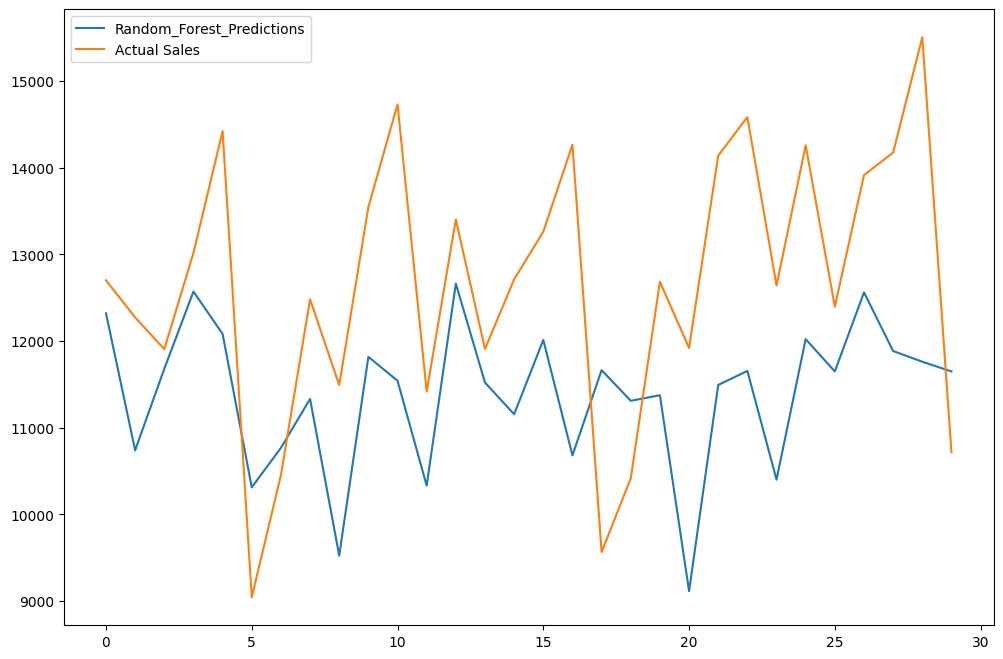

In [ ]:
pred=model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(pred,label='Random_Forest_Predictions')
plt.plot(y_test,label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

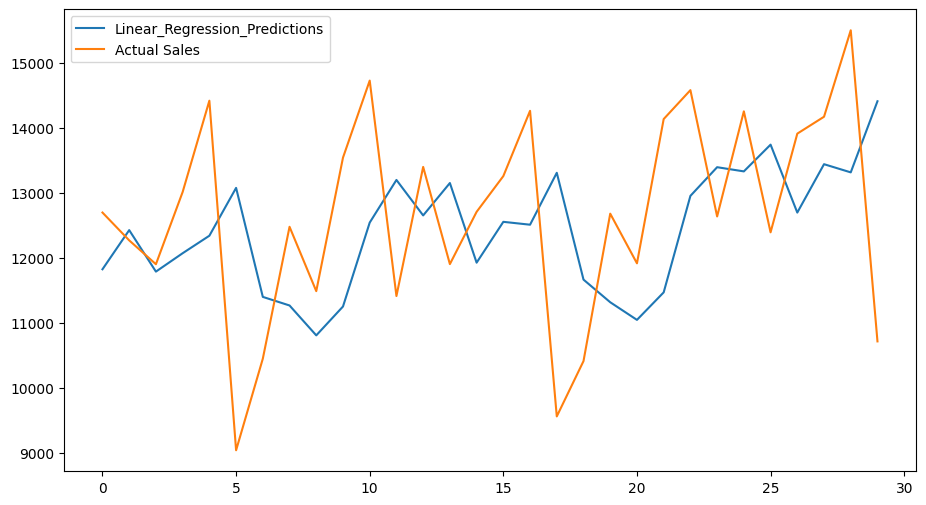

In [ ]:
lin_pred=lin_model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,6)
plt.plot(lin_pred,label='Linear_Regression_Predictions')
plt.plot(y_test,label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

## Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_rf=sqrt(mean_squared_error(pred,y_test))
rmse_lr=sqrt(mean_squared_error(lin_pred,y_test))

In [ ]:
print('Mean Squared Error for Random Forest Model is:',rmse_rf)
print('Mean Squared Error for Linear Regression Model is:',rmse_lr)

Mean Squared Error for Random Forest Model is: 1913.7762399350665
Mean Squared Error for Linear Regression Model is: 1791.496523275983


# Multivarite Time Series Forecasting || Rachiketa

## Import Library

plot_acf and plot_pacf:
- From statsmodels.graphics.tsaplots, these functions help analyze the autocorrelation and partial autocorrelation of time series data.
Used to identify suitable lag values for ARIMA or VAR models.

VARMAX:
- From statsmodels.tsa.statespace.varmax, this is used for `vector autoregression with moving averages`.
Suitable for modeling multivariate time series data.

VAR:
- From statsmodels.tsa.api, used for `vector autoregressive` models.
Helps model multiple interdependent time series.

grangercausalitytests:
- Tests whether one time series can be used to predict another (i.e., Granger causality).

adfuller:
- `Augmented Dickey-Fuller` test for checking the stationarity of time series data.

statsmodels.api as sm:
- Provides a broader set of econometric and statistical tools.


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## Read Data

In [ ]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
macro_data = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
print(macro_data.shape)  # (123, 8)
# macro_data.head()
macro_data

(123, 8)


rgnp    pgnp    ulc  gdfco    gdf  gdfim  gdfcf  gdfce
date                                                                
1959-01-01  1606.4  1608.3   47.5   36.9   37.4   26.9   32.3   23.1
1959-04-01  1637.0  1622.2   47.5   37.4   37.5   27.0   32.2   23.4
1959-07-01  1629.5  1636.2   48.7   37.6   37.6   27.1   32.4   23.4
1959-10-01  1643.4  1650.3   48.8   37.7   37.8   27.1   32.5   23.8
1960-01-01  1671.6  1664.6   49.1   37.8   37.8   27.2   32.4   23.8
...            ...     ...    ...    ...    ...    ...    ...    ...
1988-07-01  4042.7  3971.9  179.6  131.5  124.9  106.2  123.5   92.8
1988-10-01  4069.4  3995.8  181.3  133.3  126.2  107.3  124.9   92.9
1989-01-01  4106.8  4019.9  184.1  134.8  127.7  109.5  126.6   94.0
1989-04-01  4132.5  4044.1  186.1  134.8  129.3  111.1  129.0  100.6
1989-07-01  4162.9  4068.4  187.4  137.2  130.2  109.8  129.9   98.2

[123 rows x 8 columns]

## Lets see the data pattern

fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10, 6))
- plt.subplots: Creates a grid of subplots (4 rows × 2 columns = 8 subplots).

for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
- enumerate(axes.flatten()): Flattens the 2D array of axes into a 1D list for easy iteration.
i represents the index of the current subplot (from 0 to 7).
- macro_data[macro_data.columns[i]]: Retrieves the i-th column of the macro_data DataFrame.


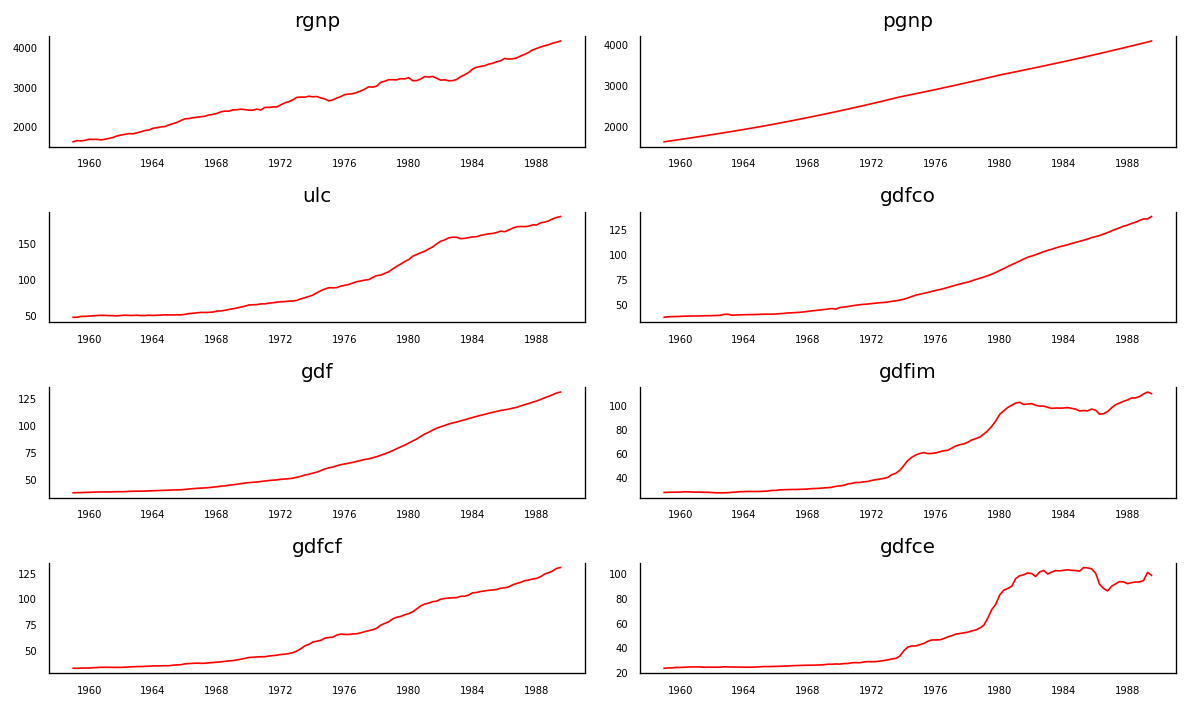

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Here we are going to use just rgnp, ulc for multivariate time series

## Checking Stationary or not

ad_fuller_result_1 = adfuller(macro_data['rgnp'].diff()[1:])
- diff(): Calculates the difference between consecutive values (i.e., Xt−Xt−1X t​−X t−1​) to help make the data stationary.
- [1:]: Skips the first NaN value created by differencing.
- adfuller: Runs the ADF test.
- rgnp: Real Gross National Product (one of the columns in macro_data).

p-value: Tests the null hypothesis:
- Null Hypothesis: Series has a unit root (not stationary).
- Low p-value (< 0.05): Reject the null hypothesis, suggesting the series is stationary.

In [ ]:
ad_fuller_result_1 = adfuller(macro_data['rgnp'].diff()[1:])

print('realgdp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_data['ulc'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realgdp
ADF Statistic: -5.427594381007333
p-value: 2.9633019848469254e-06

---------------------

realcons
ADF Statistic: -3.5760804731509097
p-value: 0.0062351318302382


## Checking Correlation
Two time series we are working with, are correated?

Grangercausalitytests(data, max_lag):

- data: A DataFrame where the first column is the dependent variable, and the second column is the independent variable.
- max_lag: Maximum number of lags to include in the test.

In [ ]:
print('rgnp causes ulc?\n')
print('------------------')
'''If P value is less than 0.05 then rgnp causes ulc
'''
granger_1 = grangercausalitytests(macro_data[['ulc', 'rgnp']], 4)

print('\nulc causes rgnp?\n')
print('------------------')
'''If P value is less than 0.05 then ulc causes rgnp
'''
granger_2 = grangercausalitytests(macro_data[['rgnp', 'ulc']], 4)

rgnp causes ulc?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.3802 , p=0.0000  , df_denom=119, df_num=1
ssr based chi2 test:   chi2=22.9444 , p=0.0000  , df=1
likelihood ratio test: chi2=21.0242 , p=0.0000  , df=1
parameter F test:         F=22.3802 , p=0.0000  , df_denom=119, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.7188  , p=0.0007  , df_denom=116, df_num=2
ssr based chi2 test:   chi2=16.1029 , p=0.0003  , df=2
likelihood ratio test: chi2=15.1179 , p=0.0005  , df=2
parameter F test:         F=7.7188  , p=0.0007  , df_denom=116, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.5231  , p=0.0001  , df_denom=113, df_num=3
ssr based chi2 test:   chi2=23.9675 , p=0.0000  , df=3
likelihood ratio test: chi2=21.8515 , p=0.0001  , df=3
parameter F test:         F=7.5231  , p=0.0001  , df_denom=113, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F

## Split the dataset

In [ ]:
macro_data = macro_data[['ulc','rgnp']]
print(macro_data.shape)

(123, 2)


In [ ]:
train_df=macro_data[:-12]
test_df=macro_data[-12:]

In [ ]:
print(test_df.shape)

(12, 2)


## Selecting max lag

we are uncertain about how much lag we are going to consider? The **`Select_0rder`** function will help us to know  

VAR(train_df.diff()[1:]):

- Initializes a VAR model using the stationary differenced data.

In [ ]:
model = VAR(train_df.diff()[1:])

In [ ]:
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        6.778       6.834       878.3       6.800
1        5.988      6.154*       398.5       6.055
2        5.942       6.220       380.9       6.054
3        5.933       6.322       377.4       6.090
4       5.793*       6.293      328.5*      5.995*
5        5.873       6.484       356.3       6.120
6        5.828       6.550       341.1       6.119
7        5.894       6.727       365.0       6.230
8        5.890       6.835       364.8       6.271
9        5.942       6.998       385.8       6.368
10       5.930       7.097       382.9       6.401
11       5.913       7.191       378.5       6.428
12       5.885       7.274       370.7       6.445
13       5.925       7.424       388.6       6.529
14       5.882       7.493       376.0       6.532
15       5.950       7.672       406.9       6.644
16       5.933       7.766     

## Build the model

We will use non stationary data.
- notice: we are using VARMAX model which means we have to specify the orders for autoregressive and moving average but we are building only VAR model. so moving average doesn't exist now
- In this case, order=(4, 0) means: Use 4 autoregressive lags. No moving average component (q=0).
- enforce_stationarity=True: Ensures that the AR component satisfies the stationarity condition (constant mean and variance over time).
- disp=False: Suppresses optimization output during the fitting process. This is useful if you want a clean output without the step-by-step optimization details.

In [ ]:
var_model = VARMAX(train_df, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                           Statespace Model Results                           
Dep. Variable:        ['ulc', 'rgnp']   No. Observations:                  111
Model:                         VAR(4)   Log Likelihood              -11816.832
                          + intercept   AIC                          23675.663
Date:                Sat, 14 Dec 2024   BIC                          23732.563
Time:                        16:52:47   HQIC                         23698.746
Sample:                    01-01-1959                                         
                         - 07-01-1986                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):          36.27, 106.09   Jarque-Bera (JB):         22.30, 13.65
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.68, 0.28   Skew:                      0.67, -0.86
Prob(H) (two-sided):            0.12,

## Make prediction


In [ ]:
n_forecast = 12
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1) #start="1989-07-01",end='1999-01-01')

predictions=predict.predicted_mean

In [ ]:
predictions.columns=['ulc_predicted','rgnp_predicted']
predictions

ulc_predicted  rgnp_predicted
1986-10-01     166.504209     3570.924282
1987-01-01     242.261159     3756.091470
1987-04-01      51.366722     3557.245272
1987-07-01     266.820091     3859.494756
1987-10-01     148.909505     3483.499707
1988-01-01     169.072259     3767.976154
1988-04-01     155.826000     3636.599448
1988-07-01     208.871311     3729.693371
1988-10-01     143.306469     3569.782539
1989-01-01     196.199900     3770.543218
1989-04-01     143.539152     3593.271162
1989-07-01     207.120015     3750.243700

In [ ]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

<Axes: >

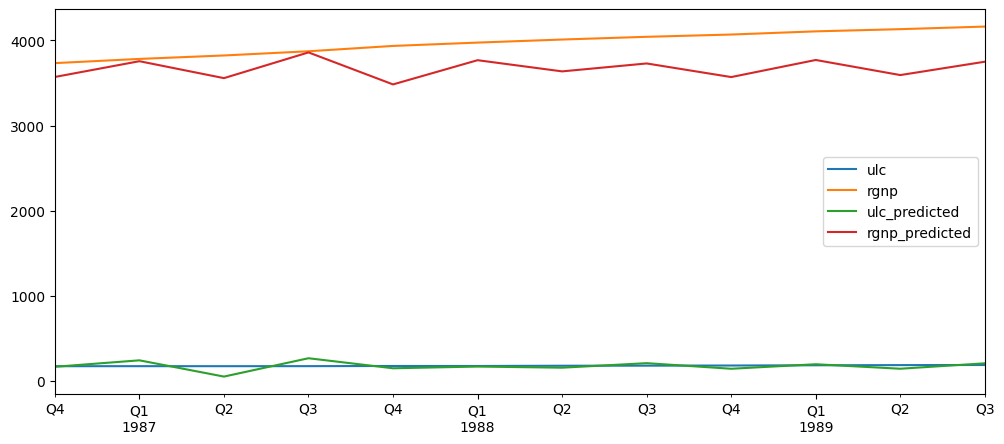

In [ ]:
test_vs_pred.plot(figsize=(12,5))

In [ ]:
from sklearn.metrics import mean_squared_error
import math
from statistics import mean

rmse_ulc=math.sqrt(mean_squared_error(predictions['ulc_predicted'],test_df['ulc']))
print('Mean value of ULC is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['ulc']),rmse_ulc))

rmse_rgnp=math.sqrt(mean_squared_error(predictions['rgnp_predicted'],test_df['rgnp']))
print('Mean value of RGNP is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['rgnp']),rmse_rgnp))

Mean value of ULC is : 178.56666666666666. Root Mean Squared Error is :53.403127690206354
Mean value of RGNP is : 3970.6916666666666. Root Mean Squared Error is :342.42887491089533


# FB Prophet Time Series Analysis || Rachiketa

In [ ]:
!pip install prophet

## Import Library

In [ ]:
import pandas as pd
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet

## Read Dataset
df.dropna(inplace=True):
- Removes any rows containing NaN (missing values) from the DataFrame.
- inplace=True ensures the changes are applied directly to df.

df.reset_index(drop=True, inplace=True):
- Resets the index of the DataFrame after removing rows.
- drop=True ensures the old index is discarded.
- inplace=True applies the reset directly to df.

In [ ]:
df = pd.read_csv('/content/MaunaLoaDailyTemps.csv')
df.dropna(inplace= True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     1821 non-null   object 
 1   MinTemp  1821 non-null   float64
 2   MaxTemp  1821 non-null   float64
 3   AvgTemp  1821 non-null   float64
 4   Sunrise  1821 non-null   int64  
 5   Sunset   1821 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 85.5+ KB


In [ ]:
df.head()

DATE  MinTemp  MaxTemp  AvgTemp  Sunrise  Sunset
0  1/1/2014     33.0     46.0     40.0      657    1756
1  1/2/2014     35.0     50.0     43.0      657    1756
2  1/3/2014     36.0     45.0     41.0      657    1757
3  1/4/2014     32.0     41.0     37.0      658    1757
4  1/5/2014     24.0     38.0     31.0      658    1758

In [ ]:
df=df[["DATE","AvgTemp"]]
df.head()

DATE  AvgTemp
0  1/1/2014     40.0
1  1/2/2014     43.0
2  1/3/2014     41.0
3  1/4/2014     37.0
4  1/5/2014     31.0

## Change Column Names for FB Prophet

In [ ]:
df.columns = ['ds','y']

In [ ]:
df['ds'] = pd.to_datetime(df['ds']) #Converting the date in the actual date so that pandas can understand
df.tail()

ds     y
1816 2018-12-26  40.0
1817 2018-12-27  39.0
1818 2018-12-28  40.0
1819 2018-12-29  42.0
1820 2018-12-30  46.0

## Plot data

usually in other time series models we have to consider stationarity, order. But in FB prophet, you don't have to worry about it. simply provide the data to FB prophet and it will do the everything for you

<Axes: xlabel='ds'>

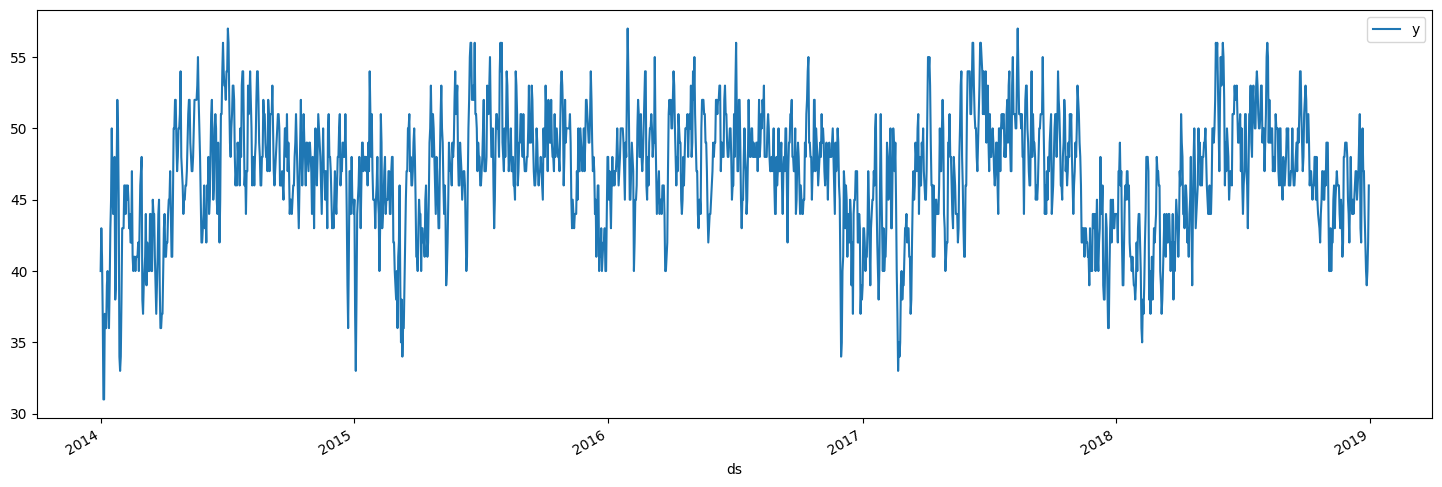

In [ ]:
df.plot(x='ds',y='y',figsize=(18,6))

In [ ]:
len(df)

1821

## Split the data

In [ ]:
train = df.iloc[:len(df)-365]
test = df.iloc[len(df)-365:]

## Make Prediction

m = Prophet():
- Initializes a Prophet model instance. When you create an instance of the Prophet class, you are preparing a forecasting model with default settings or any custom settings you pass. This step doesn't fit the data yet; it just sets up the model.

What Does make_future_dataframe Do?
- Think of m.make_future_dataframe(periods=365) as preparing a calendar of future dates for which the model will make predictions.

- Why Is This Needed?
The model needs a DataFrame of dates (the ds column) to generate forecasts.
These dates act as placeholders — "blank memory space" — for the forecasted values.

What Happens Next with predict?
- m.predict(future): Fills in this "blank space" by calculating forecasted values (yhat).



In [ ]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=365) #MS for monthly, H for hourly
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_fe79uy/m2lyr0w2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy_fe79uy/7p1teb7r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56692', 'data', 'file=/tmp/tmpy_fe79uy/m2lyr0w2.json', 'init=/tmp/tmpy_fe79uy/7p1teb7r.json', 'output', 'file=/tmp/tmpy_fe79uy/prophet_modele6o8azx7/prophet_model-20241114082701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast.tail()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1816 2018-12-25  46.192062   37.119312   45.739636    44.709209    47.868489   
1817 2018-12-26  46.191314   36.855241   45.785437    44.703400    47.873683   
1818 2018-12-27  46.190565   36.717704   45.947977    44.701321    47.878876   
1819 2018-12-28  46.189817   37.194344   46.084447    44.703178    47.884070   
1820 2018-12-29  46.189068   36.716378   45.743698    44.694607    47.889264   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
1816       -4.948818             -4.948818             -4.948818 -0.145826   
1817       -4.904014             -4.904014             -4.904014 -0.052643   
1818       -4.772865             -4.772865             -4.772865  0.098682   
1819       -4.436219             -4.436219             -4.436219  0.426907   
1820       -4.831995             -4.831995             -4.831995 -0.005789   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
1816     -0.145826     -0.145826 -4.802992     -4.802992     -4.802992   
1817     -0.052643     -0.052643 -4.851371     -4.851371     -4.851371   
1818      0.098682      0.098682 -4.871547     -4.871547     -4.871547   
1819      0.426907      0.426907 -4.863127     -4.863127     -4.863127   
1820     -0.005789     -0.005789 -4.826206     -4.826206     -4.826206   

      multiplicative_terms  multiplicative_terms_lower  \
1816                   0.0                         0.0   
1817                   0.0                         0.0   
1818                   0.0                         0.0   
1819                   0.0                         0.0   
1820                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
1816                         0.0  41.243244  
1817                         0.0  41.287300  
1818                         0.0  41.417700  
1819                         0.0  41.753597  
1820                         0.0  41.357073

Here, basically yhat is the value of predicton

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
1816 2018-12-25  41.243244   37.119312   45.739636
1817 2018-12-26  41.287300   36.855241   45.785437
1818 2018-12-27  41.417700   36.717704   45.947977
1819 2018-12-28  41.753597   37.194344   46.084447
1820 2018-12-29  41.357073   36.716378   45.743698

In [ ]:
test.tail()

ds     y
1816 2018-12-26  40.0
1817 2018-12-27  39.0
1818 2018-12-28  40.0
1819 2018-12-29  42.0
1820 2018-12-30  46.0

## USING BUILT-IN FB PROPHET VISUALIZATION

- Blue Line: The predicted yhat values (forecast).
- Shaded Area: Confidence intervals (yhat_lower, yhat_upper).
- Dots: Actual historical data (y values from the train dataset).

In [ ]:
plot_plotly(m ,forecast)

In [ ]:
plot_components_plotly(m, forecast)

/usr/local/lib/python3.10/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



## Evaluate Your Model

In [ ]:
from statsmodels.tools.eval_measures import rmse

In [ ]:
predictions = forecast.iloc[-365:]['yhat']

In [ ]:
print("Root Mean Squared Error between actual and  predicted values: ",rmse(predictions,test['y']))
print("Mean Value of Test Dataset:", test['y'].mean())

Root Mean Squared Error between actual and  predicted values:  3.460854304152485
Mean Value of Test Dataset: 46.3041095890411


# Time Series EDA || Krish Naik



## import library

In [ ]:
## Install Pandas Data Reader
!pip install pandas-datareader

In [ ]:
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime

In [ ]:
# pip install --upgrade pandas-datareader
pip install yfinance

df_tesla=pdr.get_data_yahoo('TSLA')

SyntaxError: invalid syntax (<ipython-input-41-2c6d18903d85>, line 2)

## Download data , see type, plot

In [ ]:
import yfinance as yf

df_tesla = yf.download('TSLA')
#print(df_tesla.head())
df_tesla.tail()

[*********************100%***********************]  1 of 1 completed


Price                       Adj Close       Close        High         Low  \
Ticker                           TSLA        TSLA        TSLA        TSLA   
Date                                                                        
2024-11-14 00:00:00+00:00  311.179993  311.179993  329.980011  310.369995   
2024-11-15 00:00:00+00:00  320.720001  320.720001  324.679993  309.220001   
2024-11-18 00:00:00+00:00  338.739990  338.739990  348.549988  330.010010   
2024-11-19 00:00:00+00:00  346.000000  346.000000  347.380005  332.750000   
2024-11-20 00:00:00+00:00  336.630005  336.630005  346.599915  335.899994   

Price                            Open     Volume  
Ticker                           TSLA       TSLA  
Date                                              
2024-11-14 00:00:00+00:00  327.690002  120726100  
2024-11-15 00:00:00+00:00  310.570007  114440300  
2024-11-18 00:00:00+00:00  340.730011  126547500  
2024-11-19 00:00:00+00:00  335.760010   88852500  
2024-11-20 00:00:00+00:00  345.079987   20474057

In [ ]:
type(df_tesla)

pandas.core.frame.DataFrame

<Axes: xlabel='Date'>

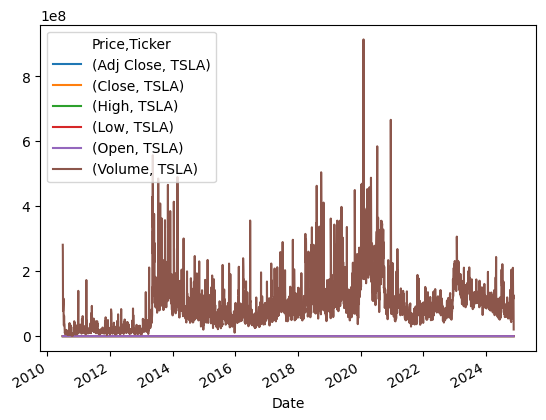

In [ ]:
df_tesla.plot()

<Axes: xlabel='Date'>

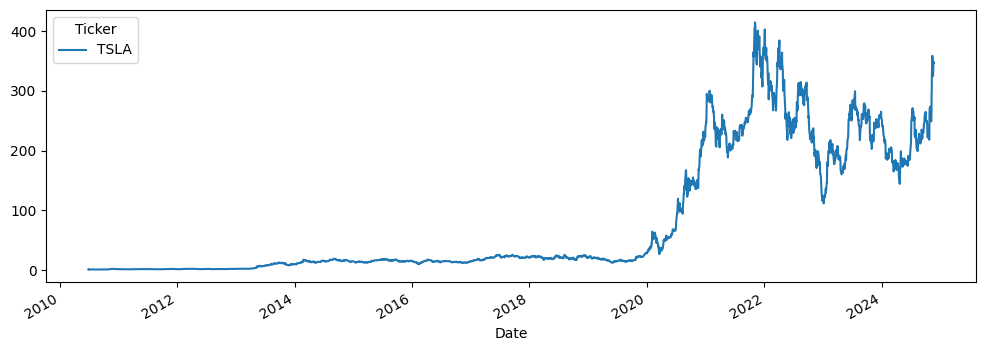

In [ ]:
df_tesla['High'].plot(figsize=(12,4))

<Axes: xlabel='Date'>

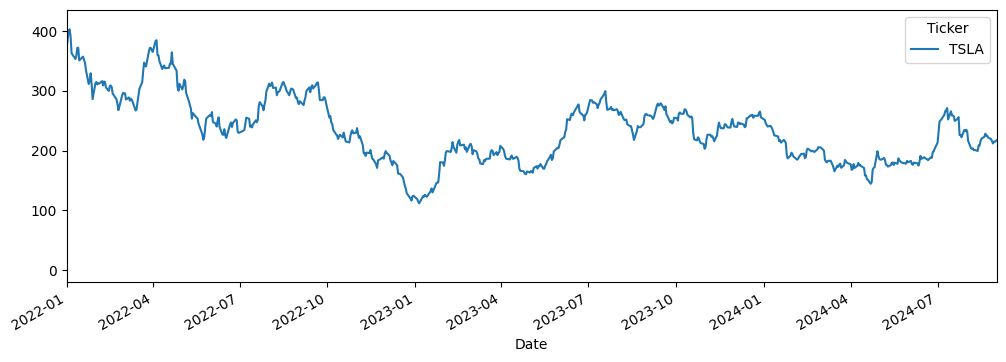

In [ ]:
## xlimit and y limit
df_tesla['High'].plot(xlim=['2022-01-01','2024-09-01'],figsize=(12,4))

<Axes: xlabel='Date'>

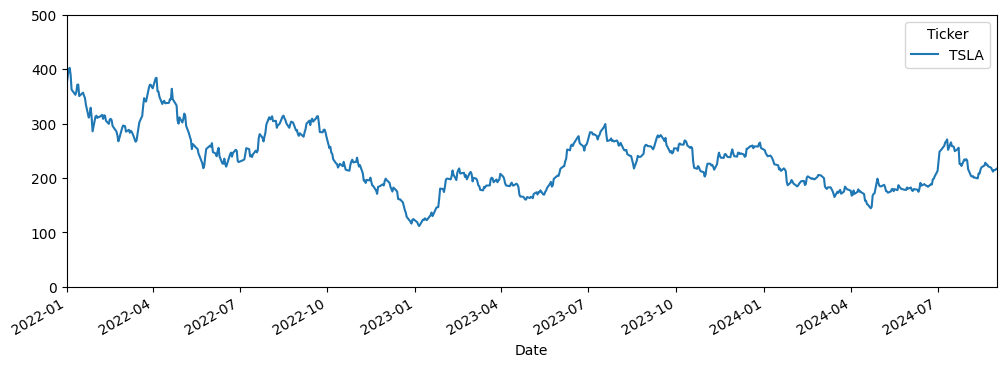

In [ ]:
## xlimit and y limit
df_tesla['High'].plot(xlim=['2022-01-01','2024-09-01'],ylim=[0,500],figsize=(12,4))

<Axes: xlabel='Date'>

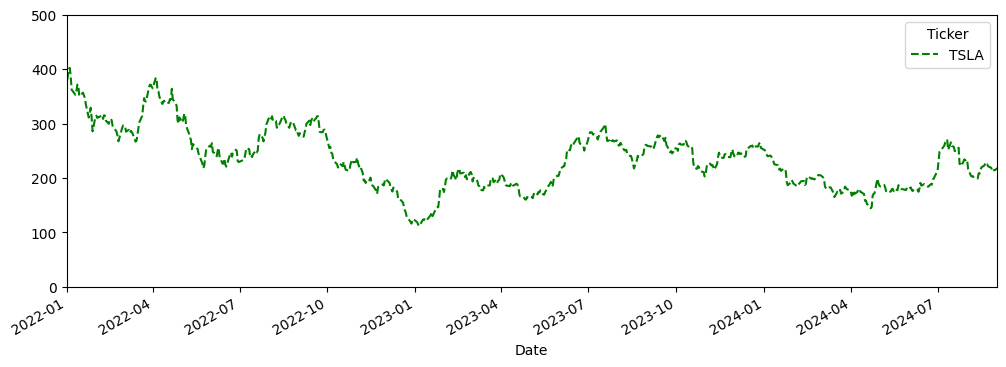

In [ ]:
df_tesla['High'].plot(xlim=['2022-01-01','2024-09-01'],ylim=[0,500],figsize=(12,4),ls='--',c='green')

In [ ]:
'''The command df_tesla.index retrieves the index of the DataFrame df_tesla.
The index represents the labels along the rows, which, in the context of
stock data, typically corresponds to the dates for each record.
'''
df_tesla.index

DatetimeIndex(['2010-06-29 00:00:00+00:00', '2010-06-30 00:00:00+00:00',
               '2010-07-01 00:00:00+00:00', '2010-07-02 00:00:00+00:00',
               '2010-07-06 00:00:00+00:00', '2010-07-07 00:00:00+00:00',
               '2010-07-08 00:00:00+00:00', '2010-07-09 00:00:00+00:00',
               '2010-07-12 00:00:00+00:00', '2010-07-13 00:00:00+00:00',
               ...
               '2024-11-07 00:00:00+00:00', '2024-11-08 00:00:00+00:00',
               '2024-11-11 00:00:00+00:00', '2024-11-12 00:00:00+00:00',
               '2024-11-13 00:00:00+00:00', '2024-11-14 00:00:00+00:00',
               '2024-11-15 00:00:00+00:00', '2024-11-18 00:00:00+00:00',
               '2024-11-19 00:00:00+00:00', '2024-11-20 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=3625, freq=None)

In [ ]:
index=df_tesla.loc['2020-01-01':'2021-09-01'].index
share_open=df_tesla.loc['2020-01-01':'2021-09-01']['Open']
share_open

Ticker                           TSLA
Date                                 
2020-01-02 00:00:00+00:00   28.299999
2020-01-03 00:00:00+00:00   29.366667
2020-01-06 00:00:00+00:00   29.364668
2020-01-07 00:00:00+00:00   30.760000
2020-01-08 00:00:00+00:00   31.580000
...                               ...
2021-08-26 00:00:00+00:00  236.103333
2021-08-27 00:00:00+00:00  235.000000
2021-08-30 00:00:00+00:00  238.240005
2021-08-31 00:00:00+00:00  244.333328
2021-09-01 00:00:00+00:00  244.693329

[421 rows x 1 columns]

In [ ]:
index

DatetimeIndex(['2020-01-02 00:00:00+00:00', '2020-01-03 00:00:00+00:00',
               '2020-01-06 00:00:00+00:00', '2020-01-07 00:00:00+00:00',
               '2020-01-08 00:00:00+00:00', '2020-01-09 00:00:00+00:00',
               '2020-01-10 00:00:00+00:00', '2020-01-13 00:00:00+00:00',
               '2020-01-14 00:00:00+00:00', '2020-01-15 00:00:00+00:00',
               ...
               '2021-08-19 00:00:00+00:00', '2021-08-20 00:00:00+00:00',
               '2021-08-23 00:00:00+00:00', '2021-08-24 00:00:00+00:00',
               '2021-08-25 00:00:00+00:00', '2021-08-26 00:00:00+00:00',
               '2021-08-27 00:00:00+00:00', '2021-08-30 00:00:00+00:00',
               '2021-08-31 00:00:00+00:00', '2021-09-01 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=421, freq=None)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

The function plt.subplots() creates:
- figure: The entire figure or canvas on which you can add one or more plots.
- axis (or axes): The specific area (or subplot) where the data is plotted.

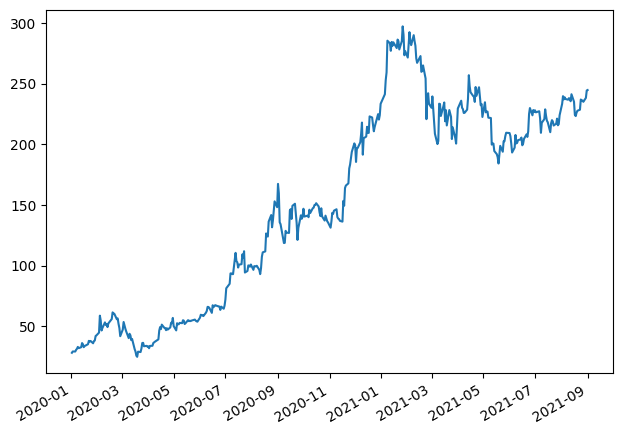

In [ ]:
figure,axis=plt.subplots()
plt.tight_layout()
## Preventing overlapping
figure.autofmt_xdate()
axis.plot(index,share_open)

`reset_index()` is useful when you want to move the index (like dates) into the DataFrame as a regular column.

In [ ]:
df_tesla=df_tesla.reset_index()


In [ ]:
'''as you can see i am getting datetime column separately.
Right now it is not an index
'''
df_tesla.head()


Price                       Date Adj Close     Close      High       Low  \
Ticker                                TSLA      TSLA      TSLA      TSLA   
0      2010-06-29 00:00:00+00:00  1.592667  1.592667  1.666667  1.169333   
1      2010-06-30 00:00:00+00:00  1.588667  1.588667  2.028000  1.553333   
2      2010-07-01 00:00:00+00:00  1.464000  1.464000  1.728000  1.351333   
3      2010-07-02 00:00:00+00:00  1.280000  1.280000  1.540000  1.247333   
4      2010-07-06 00:00:00+00:00  1.074000  1.074000  1.333333  1.055333   

Price       Open     Volume  
Ticker      TSLA       TSLA  
0       1.266667  281494500  
1       1.719333  257806500  
2       1.666667  123282000  
3       1.533333   77097000  
4       1.333333  103003500

In [ ]:
"""if I want to revert it
"""
df_tesla=df_tesla.set_index('Date',drop=True)
df_tesla.head()

Price                     Adj Close     Close      High       Low      Open  \
Ticker                         TSLA      TSLA      TSLA      TSLA      TSLA   
Date                                                                          
2010-06-29 00:00:00+00:00  1.592667  1.592667  1.666667  1.169333  1.266667   
2010-06-30 00:00:00+00:00  1.588667  1.588667  2.028000  1.553333  1.719333   
2010-07-01 00:00:00+00:00  1.464000  1.464000  1.728000  1.351333  1.666667   
2010-07-02 00:00:00+00:00  1.280000  1.280000  1.540000  1.247333  1.533333   
2010-07-06 00:00:00+00:00  1.074000  1.074000  1.333333  1.055333  1.333333   

Price                         Volume  
Ticker                          TSLA  
Date                                  
2010-06-29 00:00:00+00:00  281494500  
2010-06-30 00:00:00+00:00  257806500  
2010-07-01 00:00:00+00:00  123282000  
2010-07-02 00:00:00+00:00   77097000  
2010-07-06 00:00:00+00:00  103003500

## DateTime

In [ ]:
## datetime
from datetime import datetime

In [ ]:
datetime(2021,11,21)

datetime.datetime(2021, 11, 21, 0, 0)

In [ ]:
date = datetime.now()
date.date()
date.day
date.weekday()

2

## Time Resampling

In [ ]:
df_tesla.head()

Price                     Adj Close     Close      High       Low      Open  \
Ticker                         TSLA      TSLA      TSLA      TSLA      TSLA   
Date                                                                          
2010-06-29 00:00:00+00:00  1.592667  1.592667  1.666667  1.169333  1.266667   
2010-06-30 00:00:00+00:00  1.588667  1.588667  2.028000  1.553333  1.719333   
2010-07-01 00:00:00+00:00  1.464000  1.464000  1.728000  1.351333  1.666667   
2010-07-02 00:00:00+00:00  1.280000  1.280000  1.540000  1.247333  1.533333   
2010-07-06 00:00:00+00:00  1.074000  1.074000  1.333333  1.055333  1.333333   

Price                         Volume  
Ticker                          TSLA  
Date                                  
2010-06-29 00:00:00+00:00  281494500  
2010-06-30 00:00:00+00:00  257806500  
2010-07-01 00:00:00+00:00  123282000  
2010-07-02 00:00:00+00:00   77097000  
2010-07-06 00:00:00+00:00  103003500

The resample() function in pandas is used to group data based on a new frequency and apply some operation (e.g., summing, averaging). When you use it with rule='A', it means you're resampling your data annually.



In [ ]:
df_tesla.resample(rule='A')

<ipython-input-21-94a6bf89fa54>:1: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_tesla.resample(rule='A')


In [ ]:
df_tesla.resample(rule='A').min()

<ipython-input-22-6c39fe627685>:1: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_tesla.resample(rule='A').min()


Price                       Adj Close       Close        High         Low  \
Ticker                           TSLA        TSLA        TSLA        TSLA   
Date                                                                        
2010-12-31 00:00:00+00:00    1.053333    1.053333    1.108667    0.998667   
2011-12-31 00:00:00+00:00    1.455333    1.455333    1.484667    1.407333   
2012-12-31 00:00:00+00:00    1.519333    1.519333    1.790000    1.509333   
2013-12-31 00:00:00+00:00    2.194000    2.194000    2.225333    2.140667   
2014-12-31 00:00:00+00:00    9.289333    9.289333    9.800000    9.111333   
2015-12-31 00:00:00+00:00   12.333333   12.333333   12.619333   12.093333   
2016-12-31 00:00:00+00:00    9.578000    9.578000   10.331333    9.403333   
2017-12-31 00:00:00+00:00   14.466000   14.466000   14.688667   14.064000   
2018-12-31 00:00:00+00:00   16.704000   16.704000   17.355333   16.306000   
2019-12-31 00:00:00+00:00   11.931333   11.931333   12.445333   11.799333   
2020-12-31 00:00:00+00:00   24.081333   24.081333   26.990667   23.367332   
2021-12-31 00:00:00+00:00  187.666672  187.666672  188.736664  179.830002   
2022-12-31 00:00:00+00:00  109.099998  109.099998  116.269997  108.239998   
2023-12-31 00:00:00+00:00  108.099998  108.099998  111.750000  101.809998   
2024-12-31 00:00:00+00:00  142.050003  142.050003  144.440002  138.800003   

Price                            Open    Volume  
Ticker                           TSLA      TSLA  
Date                                             
2010-12-31 00:00:00+00:00    1.076000   1777500  
2011-12-31 00:00:00+00:00    1.452000   3594000  
2012-12-31 00:00:00+00:00    1.774667   5473500  
2013-12-31 00:00:00+00:00    2.205333   6603000  
2014-12-31 00:00:00+00:00    9.366667  19983000  
2015-12-31 00:00:00+00:00   12.388667  10620000  
2016-12-31 00:00:00+00:00    9.488000  24892500  
2017-12-31 00:00:00+00:00   14.316667  32800500  
2018-12-31 00:00:00+00:00   16.851999  46210500  
2019-12-31 00:00:00+00:00   12.073333  36984000  
2020-12-31 00:00:00+00:00   24.980000  52073100  
2021-12-31 00:00:00+00:00  184.183334  29401800  
2022-12-31 00:00:00+00:00  110.349998  41864700  
2023-12-31 00:00:00+00:00  103.000000  65125200  
2024-12-31 00:00:00+00:00  140.559998  20474057

In [ ]:
df_tesla.resample(rule='A').max()

<ipython-input-23-ad291441f546>:1: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_tesla.resample(rule='A').max()


Price                       Adj Close       Close        High         Low  \
Ticker                           TSLA        TSLA        TSLA        TSLA   
Date                                                                        
2010-12-31 00:00:00+00:00    2.364667    2.364667    2.428000    2.316667   
2011-12-31 00:00:00+00:00    2.329333    2.329333    2.333333    2.268667   
2012-12-31 00:00:00+00:00    2.534000    2.534000    2.663333    2.474000   
2013-12-31 00:00:00+00:00   12.891333   12.891333   12.966667   12.558000   
2014-12-31 00:00:00+00:00   19.069332   19.069332   19.427999   18.693333   
2015-12-31 00:00:00+00:00   18.817333   18.817333   19.110001   18.420000   
2016-12-31 00:00:00+00:00   17.694668   17.694668   17.955999   16.967333   
2017-12-31 00:00:00+00:00   25.666668   25.666668   25.974001   25.290001   
2018-12-31 00:00:00+00:00   25.304667   25.304667   25.830667   24.474667   
2019-12-31 00:00:00+00:00   28.729334   28.729334   29.020666   28.423332   
2020-12-31 00:00:00+00:00  235.223328  235.223328  239.573334  230.373337   
2021-12-31 00:00:00+00:00  409.970001  409.970001  414.496674  405.666656   
2022-12-31 00:00:00+00:00  399.926666  399.926666  402.666656  378.679993   
2023-12-31 00:00:00+00:00  293.339996  293.339996  299.290009  289.519989   
2024-12-31 00:00:00+00:00  350.000000  350.000000  358.640015  336.000000   

Price                            Open     Volume  
Ticker                           TSLA       TSLA  
Date                                              
2010-12-31 00:00:00+00:00    2.391333  281494500  
2011-12-31 00:00:00+00:00    2.308667  172767000  
2012-12-31 00:00:00+00:00    2.546000   85206000  
2013-12-31 00:00:00+00:00   12.930667  557458500  
2014-12-31 00:00:00+00:00   19.177999  490225500  
2015-12-31 00:00:00+00:00   18.680000  234744000  
2016-12-31 00:00:00+00:00   17.763332  356136000  
2017-12-31 00:00:00+00:00   25.779333  296871000  
2018-12-31 00:00:00+00:00   25.000000  504745500  
2019-12-31 00:00:00+00:00   29.000000  450091500  
2020-12-31 00:00:00+00:00  233.330002  914082000  
2021-12-31 00:00:00+00:00  411.470001  268189500  
2022-12-31 00:00:00+00:00  396.516663  221923300  
2023-12-31 00:00:00+00:00  296.040009  306590600  
2024-12-31 00:00:00+00:00  346.299988  243869700

<ipython-input-24-64e059f60d14>:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_tesla.resample(rule='A').max()['Open'].plot()


<Axes: xlabel='Date'>

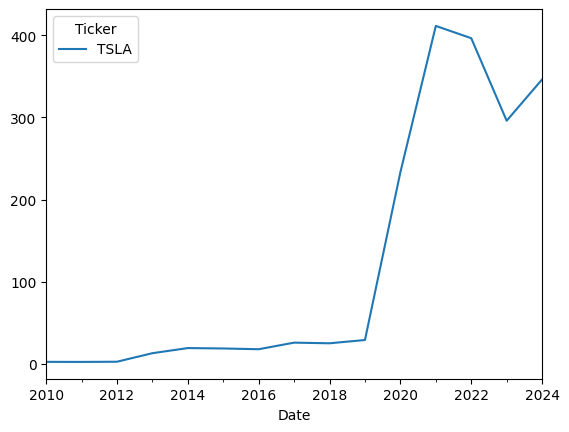

In [ ]:
##year end frequency
df_tesla.resample(rule='A').max()['Open'].plot()

In [ ]:

##quaterly start frequency
##https://towardsdatascience.com/resample-function-of-pandas-79b17ec82a78
df_tesla.resample(rule='QS').max()

Price                       Adj Close       Close        High         Low  \
Ticker                           TSLA        TSLA        TSLA        TSLA   
Date                                                                        
2010-04-01 00:00:00+00:00    1.592667    1.592667    2.028000    1.553333   
2010-07-01 00:00:00+00:00    1.465333    1.465333    1.728000    1.408667   
2010-10-01 00:00:00+00:00    2.364667    2.364667    2.428000    2.316667   
2011-01-01 00:00:00+00:00    1.896667    1.896667    1.914000    1.870000   
2011-04-01 00:00:00+00:00    2.009333    2.009333    2.100000    1.970000   
2011-07-01 00:00:00+00:00    1.982000    1.982000    2.029333    1.934000   
2011-10-01 00:00:00+00:00    2.329333    2.329333    2.333333    2.268667   
2012-01-01 00:00:00+00:00    2.529333    2.529333    2.663333    2.474000   
2012-04-01 00:00:00+00:00    2.534000    2.534000    2.564667    2.444667   
2012-07-01 00:00:00+00:00    2.397333    2.397333    2.400000    2.260000   
2012-10-01 00:00:00+00:00    2.352000    2.352000    2.386667    2.330000   
2013-01-01 00:00:00+00:00    2.632000    2.632000    2.666667    2.609333   
2013-04-01 00:00:00+00:00    7.355333    7.355333    7.660000    7.114000   
2013-07-01 00:00:00+00:00   12.891333   12.891333   12.966667   12.533333   
2013-10-01 00:00:00+00:00   12.866667   12.866667   12.948667   12.558000   
2014-01-01 00:00:00+00:00   16.989332   16.989332   17.666668   16.855333   
2014-04-01 00:00:00+00:00   16.004000   16.004000   16.299334   15.933333   
2014-07-01 00:00:00+00:00   19.069332   19.069332   19.427999   18.693333   
2014-10-01 00:00:00+00:00   17.374666   17.374666   17.702667   17.186666   
2015-01-01 00:00:00+00:00   14.732667   14.732667   15.032000   14.642667   
2015-04-01 00:00:00+00:00   17.919333   17.919333   18.094000   17.733334   
2015-07-01 00:00:00+00:00   18.817333   18.817333   19.110001   18.420000   
2015-10-01 00:00:00+00:00   16.504667   16.504667   16.656000   16.275333   
2016-01-01 00:00:00+00:00   15.888000   15.888000   15.992000   15.666667   
2016-04-01 00:00:00+00:00   17.694668   17.694668   17.955999   16.967333   
2016-07-01 00:00:00+00:00   15.652667   15.652667   15.775333   15.349333   
2016-10-01 00:00:00+00:00   14.649333   14.649333   14.920000   14.480000   
2017-01-01 00:00:00+00:00   18.732000   18.732000   19.159332   18.573999   
2017-04-01 00:00:00+00:00   25.563334   25.563334   25.799334   25.290001   
2017-07-01 00:00:00+00:00   25.666668   25.666668   25.974001   25.178667   
2017-10-01 00:00:00+00:00   23.976667   23.976667   24.200001   23.608667   
2018-01-01 00:00:00+00:00   23.827999   23.827999   24.033333   23.490667   
2018-04-01 00:00:00+00:00   24.722000   24.722000   24.915333   23.633333   
2018-07-01 00:00:00+00:00   25.304667   25.304667   25.830667   24.474667   
2018-10-01 00:00:00+00:00   25.119333   25.119333   25.299334   24.450001   
2019-01-01 00:00:00+00:00   23.153999   23.153999   23.466667   22.943333   
2019-04-01 00:00:00+00:00   19.454000   19.454000   19.744667   19.144667   
2019-07-01 00:00:00+00:00   17.658667   17.658667   17.738001   17.210667   
2019-10-01 00:00:00+00:00   28.729334   28.729334   29.020666   28.423332   
2020-01-01 00:00:00+00:00   61.161331   61.161331   64.599335   60.068001   
2020-04-01 00:00:00+00:00   71.987335   71.987335   72.512665   66.915337   
2020-07-01 00:00:00+00:00  166.106674  166.106674  167.496674  156.836670   
2020-10-01 00:00:00+00:00  235.223328  235.223328  239.573334  230.373337   
2021-01-01 00:00:00+00:00  294.363342  294.363342  300.133331  290.533325   
2021-04-01 00:00:00+00:00  254.106674  254.106674  260.263336  244.203339   
2021-07-01 00:00:00+00:00  263.786682  263.786682  266.333344  258.333344   
2021-10-01 00:00:00+00:00  409.970001  409.970001  414.496674  405.666656   
2022-01-01 00:00:00+00:00  399.926666  399.926666  402.666656  378.679993   
2022-04-01 00:00:00+00:00  381.816681  381.816681  384.290009  362.433319

<Axes: xlabel='Date'>

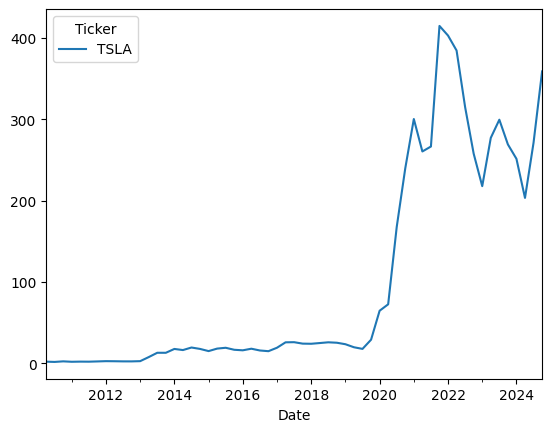

In [ ]:
df_tesla.resample(rule='QS').max()['High'].plot()

In [ ]:
##Business End Frequency
##https://towardsdatascience.com/resample-function-of-pandas-79b17ec82a78
df_tesla.resample(rule='BA').max()

<ipython-input-27-58d030c56ff4>:3: FutureWarning: 'BA' is deprecated and will be removed in a future version, please use 'BYE' instead.
  df_tesla.resample(rule='BA').max()


Price                       Adj Close       Close        High         Low  \
Ticker                           TSLA        TSLA        TSLA        TSLA   
Date                                                                        
2010-12-31 00:00:00+00:00    2.364667    2.364667    2.428000    2.316667   
2011-12-30 00:00:00+00:00    2.329333    2.329333    2.333333    2.268667   
2012-12-31 00:00:00+00:00    2.534000    2.534000    2.663333    2.474000   
2013-12-31 00:00:00+00:00   12.891333   12.891333   12.966667   12.558000   
2014-12-31 00:00:00+00:00   19.069332   19.069332   19.427999   18.693333   
2015-12-31 00:00:00+00:00   18.817333   18.817333   19.110001   18.420000   
2016-12-30 00:00:00+00:00   17.694668   17.694668   17.955999   16.967333   
2017-12-29 00:00:00+00:00   25.666668   25.666668   25.974001   25.290001   
2018-12-31 00:00:00+00:00   25.304667   25.304667   25.830667   24.474667   
2019-12-31 00:00:00+00:00   28.729334   28.729334   29.020666   28.423332   
2020-12-31 00:00:00+00:00  235.223328  235.223328  239.573334  230.373337   
2021-12-31 00:00:00+00:00  409.970001  409.970001  414.496674  405.666656   
2022-12-30 00:00:00+00:00  399.926666  399.926666  402.666656  378.679993   
2023-12-29 00:00:00+00:00  293.339996  293.339996  299.290009  289.519989   
2024-12-31 00:00:00+00:00  350.000000  350.000000  358.640015  336.000000   

Price                            Open     Volume  
Ticker                           TSLA       TSLA  
Date                                              
2010-12-31 00:00:00+00:00    2.391333  281494500  
2011-12-30 00:00:00+00:00    2.308667  172767000  
2012-12-31 00:00:00+00:00    2.546000   85206000  
2013-12-31 00:00:00+00:00   12.930667  557458500  
2014-12-31 00:00:00+00:00   19.177999  490225500  
2015-12-31 00:00:00+00:00   18.680000  234744000  
2016-12-30 00:00:00+00:00   17.763332  356136000  
2017-12-29 00:00:00+00:00   25.779333  296871000  
2018-12-31 00:00:00+00:00   25.000000  504745500  
2019-12-31 00:00:00+00:00   29.000000  450091500  
2020-12-31 00:00:00+00:00  233.330002  914082000  
2021-12-31 00:00:00+00:00  411.470001  268189500  
2022-12-30 00:00:00+00:00  396.516663  221923300  
2023-12-29 00:00:00+00:00  296.040009  306590600  
2024-12-31 00:00:00+00:00  346.299988  243869700

In [ ]:
df_tesla.resample(rule='BQS').max()

Price                       Adj Close       Close        High         Low  \
Ticker                           TSLA        TSLA        TSLA        TSLA   
Date                                                                        
2010-04-01 00:00:00+00:00    1.592667    1.592667    2.028000    1.553333   
2010-07-01 00:00:00+00:00    1.465333    1.465333    1.728000    1.408667   
2010-10-01 00:00:00+00:00    2.364667    2.364667    2.428000    2.316667   
2011-01-03 00:00:00+00:00    1.896667    1.896667    1.914000    1.870000   
2011-04-01 00:00:00+00:00    2.009333    2.009333    2.100000    1.970000   
2011-07-01 00:00:00+00:00    1.982000    1.982000    2.029333    1.934000   
2011-10-03 00:00:00+00:00    2.329333    2.329333    2.333333    2.268667   
2012-01-02 00:00:00+00:00    2.529333    2.529333    2.663333    2.474000   
2012-04-02 00:00:00+00:00    2.534000    2.534000    2.564667    2.444667   
2012-07-02 00:00:00+00:00    2.397333    2.397333    2.400000    2.260000   
2012-10-01 00:00:00+00:00    2.352000    2.352000    2.386667    2.330000   
2013-01-01 00:00:00+00:00    2.632000    2.632000    2.666667    2.609333   
2013-04-01 00:00:00+00:00    7.355333    7.355333    7.660000    7.114000   
2013-07-01 00:00:00+00:00   12.891333   12.891333   12.966667   12.533333   
2013-10-01 00:00:00+00:00   12.866667   12.866667   12.948667   12.558000   
2014-01-01 00:00:00+00:00   16.989332   16.989332   17.666668   16.855333   
2014-04-01 00:00:00+00:00   16.004000   16.004000   16.299334   15.933333   
2014-07-01 00:00:00+00:00   19.069332   19.069332   19.427999   18.693333   
2014-10-01 00:00:00+00:00   17.374666   17.374666   17.702667   17.186666   
2015-01-01 00:00:00+00:00   14.732667   14.732667   15.032000   14.642667   
2015-04-01 00:00:00+00:00   17.919333   17.919333   18.094000   17.733334   
2015-07-01 00:00:00+00:00   18.817333   18.817333   19.110001   18.420000   
2015-10-01 00:00:00+00:00   16.504667   16.504667   16.656000   16.275333   
2016-01-01 00:00:00+00:00   15.888000   15.888000   15.992000   15.666667   
2016-04-01 00:00:00+00:00   17.694668   17.694668   17.955999   16.967333   
2016-07-01 00:00:00+00:00   15.652667   15.652667   15.775333   15.349333   
2016-10-03 00:00:00+00:00   14.649333   14.649333   14.920000   14.480000   
2017-01-02 00:00:00+00:00   18.732000   18.732000   19.159332   18.573999   
2017-04-03 00:00:00+00:00   25.563334   25.563334   25.799334   25.290001   
2017-07-03 00:00:00+00:00   25.666668   25.666668   25.974001   25.178667   
2017-10-02 00:00:00+00:00   23.976667   23.976667   24.200001   23.608667   
2018-01-01 00:00:00+00:00   23.827999   23.827999   24.033333   23.490667   
2018-04-02 00:00:00+00:00   24.722000   24.722000   24.915333   23.633333   
2018-07-02 00:00:00+00:00   25.304667   25.304667   25.830667   24.474667   
2018-10-01 00:00:00+00:00   25.119333   25.119333   25.299334   24.450001   
2019-01-01 00:00:00+00:00   23.153999   23.153999   23.466667   22.943333   
2019-04-01 00:00:00+00:00   19.454000   19.454000   19.744667   19.144667   
2019-07-01 00:00:00+00:00   17.658667   17.658667   17.738001   17.210667   
2019-10-01 00:00:00+00:00   28.729334   28.729334   29.020666   28.423332   
2020-01-01 00:00:00+00:00   61.161331   61.161331   64.599335   60.068001   
2020-04-01 00:00:00+00:00   71.987335   71.987335   72.512665   66.915337   
2020-07-01 00:00:00+00:00  166.106674  166.106674  167.496674  156.836670   
2020-10-01 00:00:00+00:00  235.223328  235.223328  239.573334  230.373337   
2021-01-01 00:00:00+00:00  294.363342  294.363342  300.133331  290.533325   
2021-04-01 00:00:00+00:00  254.106674  254.106674  260.263336  244.203339   
2021-07-01 00:00:00+00:00  263.786682  263.786682  266.333344  258.333344   
2021-10-01 00:00:00+00:00  409.970001  409.970001  414.496674  405.666656   
2022-01-03 00:00:00+00:00  399.926666  399.926666  402.666656  378.679993   
2022-04-01 00:00:00+00:00  381.816681  381.816681  384.290009  362.433319

<ipython-input-29-edfbddaa0627>:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_tesla['Open'].resample(rule='A').mean().plot(kind='bar')


<Axes: xlabel='Date'>

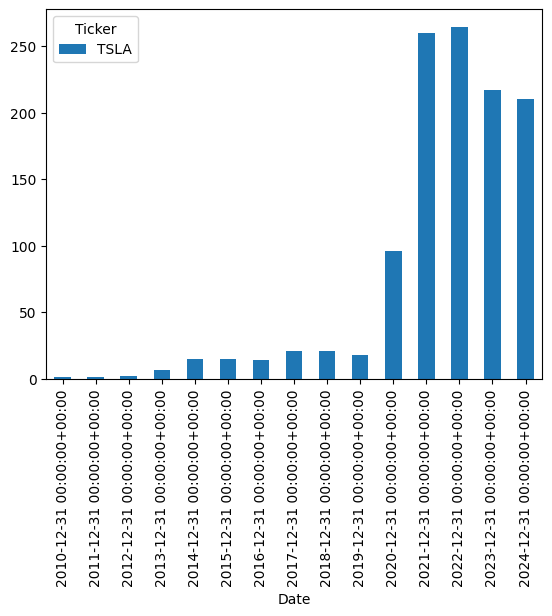

In [ ]:
##plotting
df_tesla['Open'].resample(rule='A').mean().plot(kind='bar')

<ipython-input-30-6ccccfdfc8e0>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_tesla['Open'].resample(rule='M').max().plot(kind='bar',figsize=(15,6))


<Axes: xlabel='Date'>

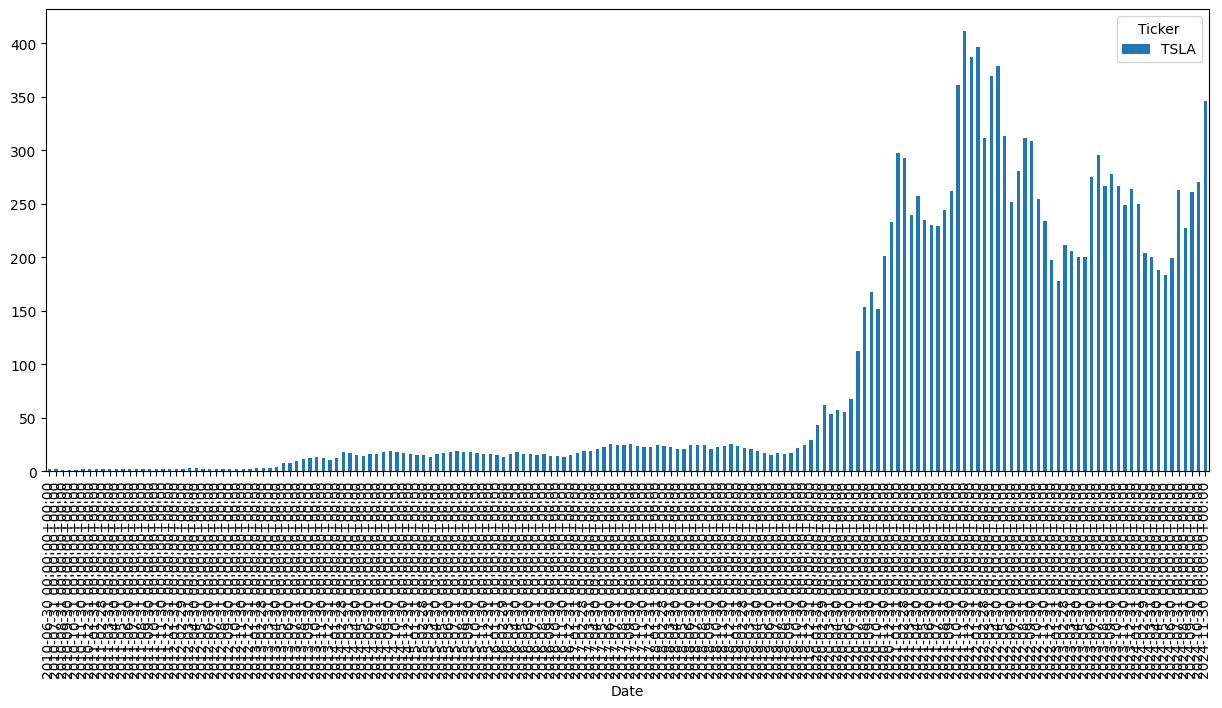

In [ ]:
df_tesla['Open'].resample(rule='M').max().plot(kind='bar',figsize=(15,6))

- rolling(11): Creates a rolling window of size 11. This means calculations will be performed over a sliding window of 11 consecutive rows.
- max(): For each rolling window of 11 rows, it computes the maximum value in that window.

The first 10 rows will have NaN because there aren't enough previous rows to fill the rolling window of size 11.

In [ ]:
df_tesla['High'].rolling(11).max().head(20)

Ticker                         TSLA
Date                               
2010-06-29 00:00:00+00:00       NaN
2010-06-30 00:00:00+00:00       NaN
2010-07-01 00:00:00+00:00       NaN
2010-07-02 00:00:00+00:00       NaN
2010-07-06 00:00:00+00:00       NaN
2010-07-07 00:00:00+00:00       NaN
2010-07-08 00:00:00+00:00       NaN
2010-07-09 00:00:00+00:00       NaN
2010-07-12 00:00:00+00:00       NaN
2010-07-13 00:00:00+00:00       NaN
2010-07-14 00:00:00+00:00  2.028000
2010-07-15 00:00:00+00:00  2.028000
2010-07-16 00:00:00+00:00  1.728000
2010-07-19 00:00:00+00:00  1.540000
2010-07-20 00:00:00+00:00  1.483333
2010-07-21 00:00:00+00:00  1.483333
2010-07-22 00:00:00+00:00  1.483333
2010-07-23 00:00:00+00:00  1.483333
2010-07-26 00:00:00+00:00  1.483333
2010-07-27 00:00:00+00:00  1.483333

In [ ]:
df_tesla.head()

Price                     Adj Close     Close      High       Low      Open  \
Ticker                         TSLA      TSLA      TSLA      TSLA      TSLA   
Date                                                                          
2010-06-29 00:00:00+00:00  1.592667  1.592667  1.666667  1.169333  1.266667   
2010-06-30 00:00:00+00:00  1.588667  1.588667  2.028000  1.553333  1.719333   
2010-07-01 00:00:00+00:00  1.464000  1.464000  1.728000  1.351333  1.666667   
2010-07-02 00:00:00+00:00  1.280000  1.280000  1.540000  1.247333  1.533333   
2010-07-06 00:00:00+00:00  1.074000  1.074000  1.333333  1.055333  1.333333   

Price                         Volume  
Ticker                          TSLA  
Date                                  
2010-06-29 00:00:00+00:00  281494500  
2010-06-30 00:00:00+00:00  257806500  
2010-07-01 00:00:00+00:00  123282000  
2010-07-02 00:00:00+00:00   77097000  
2010-07-06 00:00:00+00:00  103003500

In [ ]:
df_tesla['Open:30 days rolling']=df_tesla['Open'].rolling(30).mean()
df_tesla.head(31)

Price                     Adj Close     Close      High       Low      Open  \
Ticker                         TSLA      TSLA      TSLA      TSLA      TSLA   
Date                                                                          
2010-06-29 00:00:00+00:00  1.592667  1.592667  1.666667  1.169333  1.266667   
2010-06-30 00:00:00+00:00  1.588667  1.588667  2.028000  1.553333  1.719333   
2010-07-01 00:00:00+00:00  1.464000  1.464000  1.728000  1.351333  1.666667   
2010-07-02 00:00:00+00:00  1.280000  1.280000  1.540000  1.247333  1.533333   
2010-07-06 00:00:00+00:00  1.074000  1.074000  1.333333  1.055333  1.333333   
2010-07-07 00:00:00+00:00  1.053333  1.053333  1.108667  0.998667  1.093333   
2010-07-08 00:00:00+00:00  1.164000  1.164000  1.168000  1.038000  1.076000   
2010-07-09 00:00:00+00:00  1.160000  1.160000  1.193333  1.103333  1.172000   
2010-07-12 00:00:00+00:00  1.136667  1.136667  1.204667  1.133333  1.196667   
2010-07-13 00:00:00+00:00  1.209333  1.209333  1.242667  1.126667  1.159333   
2010-07-14 00:00:00+00:00  1.322667  1.322667  1.343333  1.184000  1.196000   
2010-07-15 00:00:00+00:00  1.326000  1.326000  1.433333  1.266667  1.329333   
2010-07-16 00:00:00+00:00  1.376000  1.376000  1.420000  1.336667  1.380000   
2010-07-19 00:00:00+00:00  1.460667  1.460667  1.483333  1.394667  1.424667   
2010-07-20 00:00:00+00:00  1.353333  1.353333  1.456667  1.336667  1.456667   
2010-07-21 00:00:00+00:00  1.348000  1.348000  1.393333  1.300000  1.377333   
2010-07-22 00:00:00+00:00  1.400000  1.400000  1.416667  1.358000  1.366667   
2010-07-23 00:00:00+00:00  1.419333  1.419333  1.437333  1.404000  1.412667   
2010-07-26 00:00:00+00:00  1.396667  1.396667  1.433333  1.353333  1.433333   
2010-07-27 00:00:00+00:00  1.370000  1.370000  1.412000  1.350667  1.394000   
2010-07-28 00:00:00+00:00  1.381333  1.381333  1.393333  1.367333  1.370000   
2010-07-29 00:00:00+00:00  1.356667  1.356667  1.392000  1.333333  1.384667   
2010-07-30 00:00:00+00:00  1.329333  1.329333  1.362667  1.303333  1.346667   
2010-08-02 00:00:00+00:00  1.394667  1.394667  1.398000  1.355333  1.366667   
2010-08-03 00:00:00+00:00  1.463333  1.463333  1.463333  1.388000  1.400000   
2010-08-04 00:00:00+00:00  1.417333  1.417333  1.478667  1.390000  1.463333   
2010-08-05 00:00:00+00:00  1.363333  1.363333  1.436667  1.336667  1.436000   
2010-08-06 00:00:00+00:00  1.306000  1.306000  1.344000  1.301333  1.340000   
2010-08-09 00:00:00+00:00  1.306667  1.306667  1.332000  1.296667  1.326667   
2010-08-10 00:00:00+00:00  1.268667  1.268667  1.310000  1.254667  1.310000   
2010-08-11 00:00:00+00:00  1.193333  1.193333  1.258667  1.190000  1.246000   

Price                         Volume Open:30 days rolling  
Ticker                          TSLA                       
Date                                                       
2010-06-29 00:00:00+00:00  281494500                  NaN  
2010-06-30 00:00:00+00:00  257806500                  NaN  
2010-07-01 00:00:00+00:00  123282000                  NaN  
2010-07-02 00:00:00+00:00   77097000                  NaN  
2010-07-06 00:00:00+00:00  103003500                  NaN  
2010-07-07 00:00:00+00:00  103825500                  NaN  
2010-07-08 00:00:00+00:00  115671000                  NaN  
2010-07-09 00:00:00+00:00   60759000                  NaN  
2010-07-12 00:00:00+00:00   33037500                  NaN  
2010-07-13 00:00:00+00:00   40201500                  NaN  
2010-07-14 00:00:00+00:00   62928000                  NaN  
2010-07-15 00:00:00+00:00   56097000                  NaN  
2010-07-16 00:00:00+00:00   39319500                  NaN  
2010-07-19 00:00:00+00:00   37297500                  NaN  
2010-07-20 00:00:00+00:00   27379500                  NaN  
2010-07-21 00:00:00+00:00   18787500                  NaN  
2010-07-22 00:00:00+00:00   14367000                  NaN  
2010-07-23 00:00:00+00:00    9804000                  NaN  
2010-07-26 00:00:00+00:00   13833000                 

<Axes: xlabel='Date'>

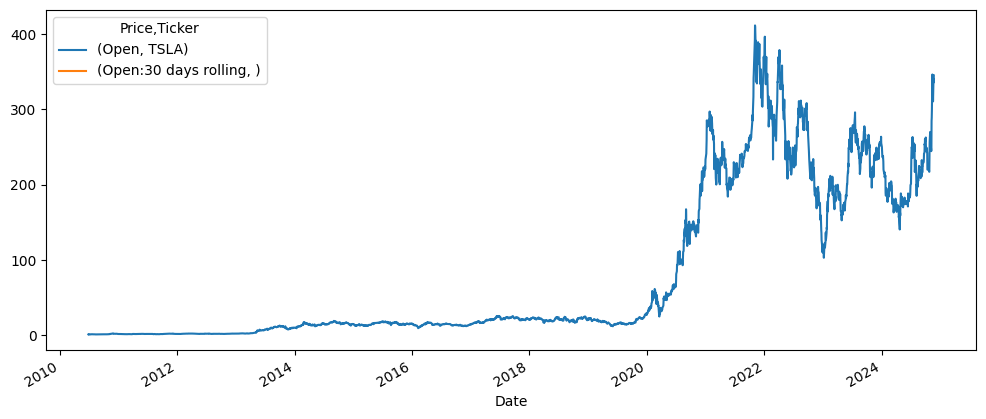

In [ ]:
df_tesla[['Open','Open:30 days rolling']].plot(figsize=(12,5))

# ARIMA & SARIMA || Krish Naik

## Import Library and see DataSet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sms
import pandas as pd

%matplotlib inline

In [ ]:
df_airline=pd.read_csv('airline_passengers.csv')
df_airline.head()

Month  Thousands of Passengers
0  1949-01                    112.0
1  1949-02                    118.0
2  1949-03                    132.0
3  1949-04                    129.0
4  1949-05                    121.0

In [ ]:
df_airline.isnull().sum()

Month                      0
Thousands of Passengers    1
dtype: int64

In [ ]:
df_airline.tail()

Month  \
140                                            1960-09   
141                                            1960-10   
142                                            1960-11   
143                                            1960-12   
144  International airline passengers: monthly tota...   

     Thousands of Passengers  
140                    508.0  
141                    461.0  
142                    390.0  
143                    432.0  
144                      NaN

In [ ]:
df_airline.dropna(axis=0,inplace=True)

1. dropna(axis=0):

- axis=0 indicates that rows containing NaN values will be removed.

- If you wanted to remove columns with NaN values instead, you would use axis=1.

2. inplace=True:

- Makes the change directly to the df_airline DataFrame without needing to assign the result back to it.

- If inplace=False (default), the operation would return a new DataFrame with the NaN rows removed, leaving the original DataFrame unchanged.

In [ ]:
df_airline.isnull().sum()

Month                      0
Thousands of Passengers    0
dtype: int64

In [ ]:
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    144 non-null    object 
 1   Thousands of Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


In [ ]:
df_airline['Month']=pd.to_datetime(df_airline['Month'])

In [ ]:
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [ ]:
df_airline.head()

Month  Thousands of Passengers
0 1949-01-01                    112.0
1 1949-02-01                    118.0
2 1949-03-01                    132.0
3 1949-04-01                    129.0
4 1949-05-01                    121.0

1. set_index('Month'):

- This specifies that the column 'Month' should become the new index of the DataFrame.
- An index is used to label the rows of the DataFrame, making data easier to query and analyze.
2. WHy this Change
- When working with time series data, setting a time-related column (e.g., 'Month') as the index makes it easier to perform operations like resampling, slicing, and aggregating data over time.
- Queries like df_airline.loc['2020-01-01'] become more intuitive and faster because 'Month' is the index.


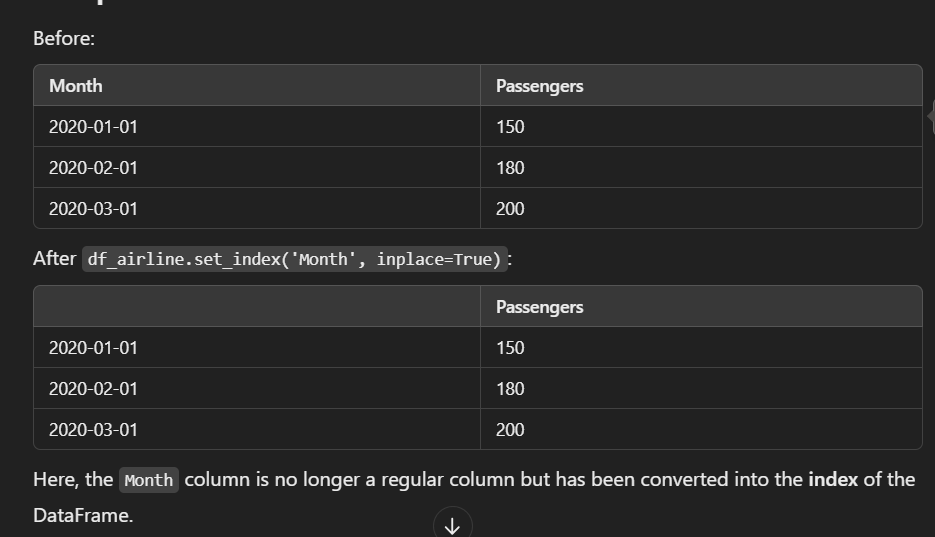

In [ ]:
df_airline.set_index('Month',inplace=True)

In [ ]:
df_airline.head()

Thousands of Passengers
Month                              
1949-01-01                    112.0
1949-02-01                    118.0
1949-03-01                    132.0
1949-04-01                    129.0
1949-05-01                    121.0

<Axes: xlabel='Month'>

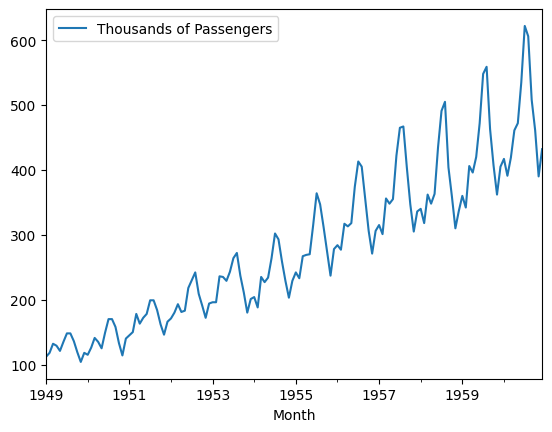

In [ ]:
df_airline.plot()

## Dicky Fuller Test for Stationarity Check

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adf_test(df_airline['Thousands of Passengers'])

ADF Statistics: 0.8153688792060528
p- value: 0.9918802434376411
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Making Differencing for Converting Stationarity

In [ ]:
## Use Techniques Differencing
'''What Does shift(1) Do?
shift(1) moves all the values in a column down by one row, introducing a NaN at the top.
It helps align each value with its previous value in the dataset.
'''
df_airline['Passengers First Difference']=df_airline['Thousands of Passengers']-df_airline['Thousands of Passengers'].shift(1)

In [ ]:
df_airline.head()

Thousands of Passengers  Passengers First Difference
Month                                                           
1949-01-01                    112.0                          NaN
1949-02-01                    118.0                          6.0
1949-03-01                    132.0                         14.0
1949-04-01                    129.0                         -3.0
1949-05-01                    121.0                         -8.0

In [ ]:
'''
.dropna() removes these NaN rows to avoid errors during the ADF test.
'''
adf_test(df_airline['Passengers First Difference'].dropna())

ADF Statistics: -2.829266824169999
p- value: 0.05421329028382552
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [ ]:
## Use Techniques Differencing
df_airline['Passengers Second Difference']=df_airline['Passengers First Difference']-df_airline['Passengers First Difference'].shift(1)

In [ ]:
adf_test(df_airline['Passengers Second Difference'].dropna())

ADF Statistics: -16.38423154246854
p- value: 2.7328918500140445e-29
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
### 12 months
## Use Techniques Differencing
df_airline['Passengers 12 Difference']=df_airline['Thousands of Passengers']-df_airline['Thousands of Passengers'].shift(12)

In [ ]:
adf_test(df_airline['Passengers 12 Difference'].dropna())

ADF Statistics: -3.383020726492481
p- value: 0.011551493085514952
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


## ACF PACF Test

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

1. Statistical Basis:
- The confidence intervals are typically based on the assumption that the time series is white noise (random with no autocorrelation).
- If the series is white noise, the autocorrelations at all lags should be close to zero.
- The confidence interval is set around 0 to account for random fluctuations.
2. Formula for Confidence Intervals:
- The bounds are calculated using the formula:
±1.96𝑁± N​ 1.96

- 1.96: Corresponds to the critical value of the standard normal distribution for a 95% confidence level (two-tailed test).
- N: Number of observations in the time series.
- This means: 95% of the autocorrelation values are expected to fall within this range under the null hypothesis (white noise).
- If a lag's autocorrelation value lies outside this interval, it is considered statistically significant.
3. selecting order
- from these we will select order

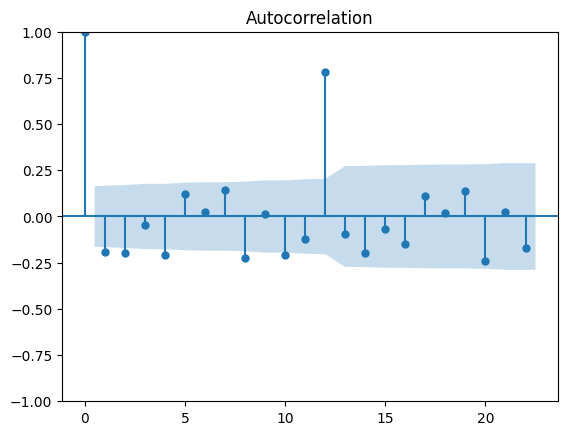

In [ ]:
acf = plot_acf(df_airline["Passengers Second Difference"].dropna())

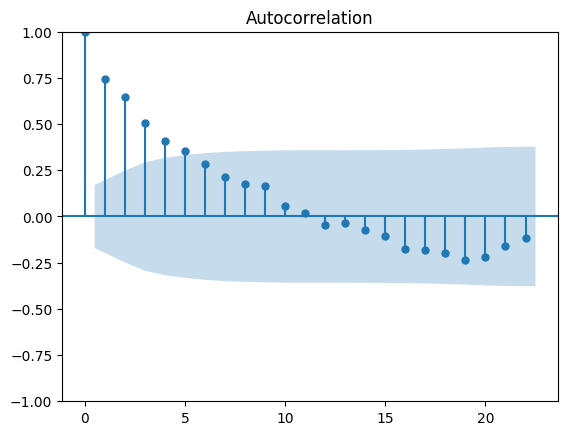

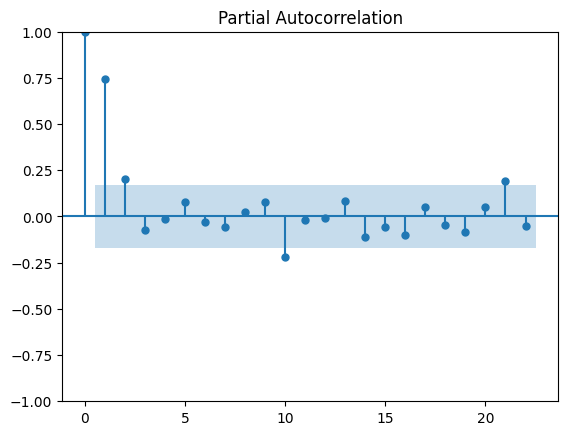

In [ ]:
acf12 = plot_acf(df_airline["Passengers 12 Difference"].dropna())
pacf12 = plot_pacf(df_airline["Passengers 12 Difference"].dropna())

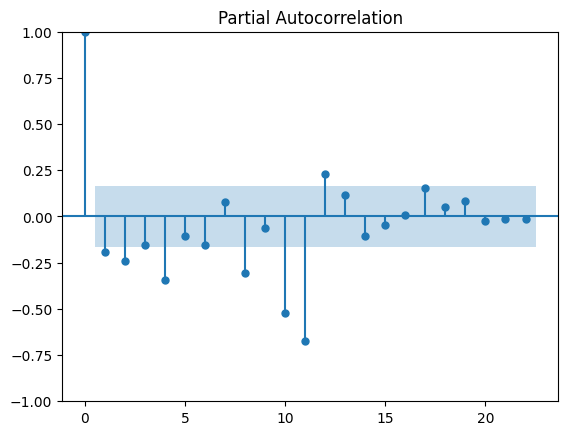

In [ ]:
result = plot_pacf(df_airline["Passengers Second Difference"].dropna())

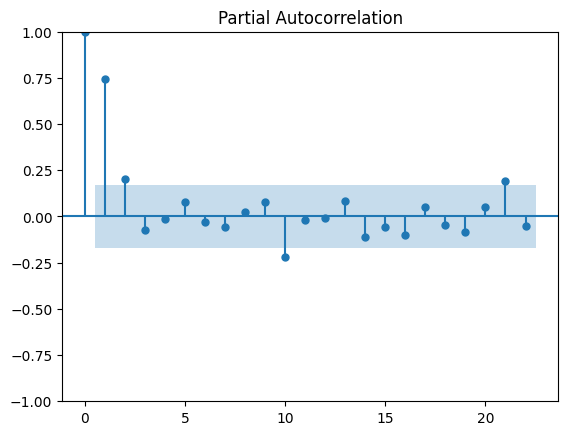

In [ ]:
pacf12 = plot_pacf(df_airline["Passengers 12 Difference"].dropna())

## Split the dataset

In [ ]:
### split train and test data
df_airline

Thousands of Passengers  Passengers First Difference  \
Month                                                              
1949-01-01                    112.0                          NaN   
1949-02-01                    118.0                          6.0   
1949-03-01                    132.0                         14.0   
1949-04-01                    129.0                         -3.0   
1949-05-01                    121.0                         -8.0   
...                             ...                          ...   
1960-08-01                    606.0                        -16.0   
1960-09-01                    508.0                        -98.0   
1960-10-01                    461.0                        -47.0   
1960-11-01                    390.0                        -71.0   
1960-12-01                    432.0                         42.0   

            Passengers Second Difference  Passengers 12 Difference  
Month                                                               
1949-01-01                           NaN                       NaN  
1949-02-01                           NaN                       NaN  
1949-03-01                           8.0                       NaN  
1949-04-01                         -17.0                       NaN  
1949-05-01                          -5.0                       NaN  
...                                  ...                       ...  
1960-08-01                        -103.0                      47.0  
1960-09-01                         -82.0                      45.0  
1960-10-01                          51.0                      54.0  
1960-11-01                         -24.0                      28.0  
1960-12-01                         113.0                      27.0  

[144 rows x 4 columns]

In [ ]:
from datetime import datetime,timedelta
train_dataset_end=datetime(1955,12,1)
test_dataset_end=datetime(1960,12,1)

In [ ]:
'''
The train_dataset_end + timedelta(days=1) shifts the start of the test data to
one day after the end of the training data (i.e., 1955-12-02).
'''
train_data=df_airline[:train_dataset_end]
test_data=df_airline[train_dataset_end+timedelta(days=1):test_dataset_end]

In [ ]:
##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

In [ ]:
test_data

Thousands of Passengers  Passengers First Difference  \
Month                                                              
1956-01-01                    284.0                          6.0   
1956-02-01                    277.0                         -7.0   
1956-03-01                    317.0                         40.0   
1956-04-01                    313.0                         -4.0   
1956-05-01                    318.0                          5.0   
1956-06-01                    374.0                         56.0   
1956-07-01                    413.0                         39.0   
1956-08-01                    405.0                         -8.0   
1956-09-01                    355.0                        -50.0   
1956-10-01                    306.0                        -49.0   
1956-11-01                    271.0                        -35.0   
1956-12-01                    306.0                         35.0   
1957-01-01                    315.0                          9.0   
1957-02-01                    301.0                        -14.0   
1957-03-01                    356.0                         55.0   
1957-04-01                    348.0                         -8.0   
1957-05-01                    355.0                          7.0   
1957-06-01                    422.0                         67.0   
1957-07-01                    465.0                         43.0   
1957-08-01                    467.0                          2.0   
1957-09-01                    404.0                        -63.0   
1957-10-01                    347.0                        -57.0   
1957-11-01                    305.0                        -42.0   
1957-12-01                    336.0                         31.0   
1958-01-01                    340.0                          4.0   
1958-02-01                    318.0                        -22.0   
1958-03-01                    362.0                         44.0   
1958-04-01                    348.0                        -14.0   
1958-05-01                    363.0                         15.0   
1958-06-01                    435.0                         72.0   
1958-07-01                    491.0                         56.0   
1958-08-01                    505.0                         14.0   
1958-09-01                    404.0                       -101.0   
1958-10-01                    359.0                        -45.0   
1958-11-01                    310.0                        -49.0   
1958-12-01                    337.0                         27.0   
1959-01-01                    360.0                         23.0   
1959-02-01                    342.0                        -18.0   
1959-03-01                    406.0                         64.0   
1959-04-01                    396.0                        -10.0   
1959-05-01                    420.0                         24.0   
1959-06-01                    472.0                         52.0   
1959-07-01                    548.0                         76.0   
1959-08-01                    559.0                         11.0   
1959-09-01                    463.0                        -96.0   
1959-10-01                    407.0                        -56.0   
1959-11-01                    362.0                        -45.0   
1959-12-01                    405.0                         43.0   
1960-01-01                    417.0                         12.0   
1960-02-01                    391.0                        -26.0   
1960-03-01                    419.0                         28.0   
1960-04-01                    461.0                         42.0   
1960-05-01                    472.0                         11.0   
1960-06-01                    535.0                         63.0   
1960-07-01                    622.0                         87.0   
1960-08-01                    606.0                        -16.0   
1960-09-01                    508.0                        -98.0   


## Create Model

In [ ]:
## create a ARIMA model
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
train_data

Thousands of Passengers  Passengers First Difference  \
Month                                                              
1949-01-01                    112.0                          NaN   
1949-02-01                    118.0                          6.0   
1949-03-01                    132.0                         14.0   
1949-04-01                    129.0                         -3.0   
1949-05-01                    121.0                         -8.0   
...                             ...                          ...   
1955-08-01                    347.0                        -17.0   
1955-09-01                    312.0                        -35.0   
1955-10-01                    274.0                        -38.0   
1955-11-01                    237.0                        -37.0   
1955-12-01                    278.0                         41.0   

            Passengers 12 Difference  Passengers Second Difference  
Month                                                               
1949-01-01                       NaN                           NaN  
1949-02-01                       NaN                           NaN  
1949-03-01                       NaN                           8.0  
1949-04-01                       NaN                         -17.0  
1949-05-01                       NaN                          -5.0  
...                              ...                           ...  
1955-08-01                      54.0                         -66.0  
1955-09-01                      53.0                         -18.0  
1955-10-01                      45.0                          -3.0  
1955-11-01                      34.0                           1.0  
1955-12-01                      49.0                          78.0  

[84 rows x 4 columns]

In [ ]:
model_ARIMA=ARIMA(train_data['Thousands of Passengers'],order=(10,2,0))

In [ ]:
model_Arima_fit=model_ARIMA.fit()

In [ ]:
model_Arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                   84
Model:                     ARIMA(10, 2, 0)   Log Likelihood                -357.239
Date:                     Sat, 14 Dec 2024   AIC                            736.477
Time:                             17:01:41   BIC                            762.951
Sample:                         01-01-1949   HQIC                           747.106
                              - 12-01-1955                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5166      0.121     -4.262      0.000      -0.754      -0.279
ar.L2         -0.7204      0.121     -5.940      0.000      -0.958      -0.483
ar.L3         -0.4857      0.125     -3.876      0.000      -0.731      -0.240
ar.L4         -0.7505      0.129     -5.819      0.000      -1.003      -0.498
ar.L5         -0.5062      0.169     -2.991      0.003      -0.838      -0.175
ar.L6         -0.5200      0.141     -3.683      0.000      -0.797      -0.243
ar.L7         -0.3051      0.143     -2.127      0.033      -0.586      -0.024
ar.L8         -0.5939      0.155     -3.833      0.000      -0.898      -0.290
ar.L9         -0.2963      0.132     -2.241      0.025      -0.555      -0.037
ar.L10        -0.4825      0.110     -4.376      0.000      -0.699      -0.266
sigma2       336.0939     66.064      5.087      0.000     206.612     465.576
===================================================================================
Ljung-Box (L1) (Q):                  10.86   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.00   Prob(JB):                         0.54
Heteroskedasticity (H):               2.85   Skew:                             0.24
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
test_data

Thousands of Passengers  Passengers First Difference  \
Month                                                              
1956-01-01                    284.0                          6.0   
1956-02-01                    277.0                         -7.0   
1956-03-01                    317.0                         40.0   
1956-04-01                    313.0                         -4.0   
1956-05-01                    318.0                          5.0   
1956-06-01                    374.0                         56.0   
1956-07-01                    413.0                         39.0   
1956-08-01                    405.0                         -8.0   
1956-09-01                    355.0                        -50.0   
1956-10-01                    306.0                        -49.0   
1956-11-01                    271.0                        -35.0   
1956-12-01                    306.0                         35.0   
1957-01-01                    315.0                          9.0   
1957-02-01                    301.0                        -14.0   
1957-03-01                    356.0                         55.0   
1957-04-01                    348.0                         -8.0   
1957-05-01                    355.0                          7.0   
1957-06-01                    422.0                         67.0   
1957-07-01                    465.0                         43.0   
1957-08-01                    467.0                          2.0   
1957-09-01                    404.0                        -63.0   
1957-10-01                    347.0                        -57.0   
1957-11-01                    305.0                        -42.0   
1957-12-01                    336.0                         31.0   
1958-01-01                    340.0                          4.0   
1958-02-01                    318.0                        -22.0   
1958-03-01                    362.0                         44.0   
1958-04-01                    348.0                        -14.0   
1958-05-01                    363.0                         15.0   
1958-06-01                    435.0                         72.0   
1958-07-01                    491.0                         56.0   
1958-08-01                    505.0                         14.0   
1958-09-01                    404.0                       -101.0   
1958-10-01                    359.0                        -45.0   
1958-11-01                    310.0                        -49.0   
1958-12-01                    337.0                         27.0   
1959-01-01                    360.0                         23.0   
1959-02-01                    342.0                        -18.0   
1959-03-01                    406.0                         64.0   
1959-04-01                    396.0                        -10.0   
1959-05-01                    420.0                         24.0   
1959-06-01                    472.0                         52.0   
1959-07-01                    548.0                         76.0   
1959-08-01                    559.0                         11.0   
1959-09-01                    463.0                        -96.0   
1959-10-01                    407.0                        -56.0   
1959-11-01                    362.0                        -45.0   
1959-12-01                    405.0                         43.0   
1960-01-01                    417.0                         12.0   
1960-02-01                    391.0                        -26.0   
1960-03-01                    419.0                         28.0   
1960-04-01                    461.0                         42.0   
1960-05-01                    472.0                         11.0   
1960-06-01                    535.0                         63.0   
1960-07-01                    622.0                         87.0   
1960-08-01                    606.0                        -16.0   
1960-09-01                    508.0                        -98.0   


## Prediction

In [ ]:
##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

1956-01-01 00:00:00
1960-12-01 00:00:00


In [ ]:
pred=model_Arima_fit.predict(start=pred_start_date,end=pred_end_date)
residuals=test_data['Thousands of Passengers']-pred

In [ ]:
pred

1956-01-01    300.183612
1956-02-01    309.478355
1956-03-01    316.443016
1956-04-01    307.827546
1956-05-01    318.544235
1956-06-01    348.922085
1956-07-01    366.020289
1956-08-01    346.567536
1956-09-01    332.120971
1956-10-01    307.734757
1956-11-01    311.623913
1956-12-01    339.828198
1957-01-01    349.840407
1957-02-01    356.098237
1957-03-01    350.687832
1957-04-01    350.080468
1957-05-01    361.157698
1957-06-01    381.216520
1957-07-01    382.319378
1957-08-01    372.852584
1957-09-01    364.110101
1957-10-01    356.108929
1957-11-01    371.293794
1957-12-01    385.323600
1958-01-01    392.077843
1958-02-01    391.405857
1958-03-01    388.404587
1958-04-01    391.572864
1958-05-01    402.448087
1958-06-01    413.255691
1958-07-01    410.853422
1958-08-01    407.670551
1958-09-01    402.486343
1958-10-01    406.089155
1958-11-01    418.125321
1958-12-01    426.012383
1959-01-01    429.205589
1959-02-01    427.352241
1959-03-01    428.150998
1959-04-01    432.790857
1959-05-01    442.336838
1959-06-01    446.791773
1959-07-01    446.101652
1959-08-01    444.911404
1959-09-01    444.640869
1959-10-01    451.674542
1959-11-01    459.415324
1959-12-01    464.580380
1960-01-01    465.479636
1960-02-01    465.694243
1960-03-01    468.229498
1960-04-01    473.904911
1960-05-01    480.612099
1960-06-01    482.824726
1960-07-01    483.672236
1960-08-01    483.883995
1960-09-01    487.184118
1960-10-01    493.432799
1960-11-01    498.930088
1960-12-01    502.159841
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
residuals

Month
1956-01-01    -16.183612
1956-02-01    -32.478355
1956-03-01      0.556984
1956-04-01      5.172454
1956-05-01     -0.544235
1956-06-01     25.077915
1956-07-01     46.979711
1956-08-01     58.432464
1956-09-01     22.879029
1956-10-01     -1.734757
1956-11-01    -40.623913
1956-12-01    -33.828198
1957-01-01    -34.840407
1957-02-01    -55.098237
1957-03-01      5.312168
1957-04-01     -2.080468
1957-05-01     -6.157698
1957-06-01     40.783480
1957-07-01     82.680622
1957-08-01     94.147416
1957-09-01     39.889899
1957-10-01     -9.108929
1957-11-01    -66.293794
1957-12-01    -49.323600
1958-01-01    -52.077843
1958-02-01    -73.405857
1958-03-01    -26.404587
1958-04-01    -43.572864
1958-05-01    -39.448087
1958-06-01     21.744309
1958-07-01     80.146578
1958-08-01     97.329449
1958-09-01      1.513657
1958-10-01    -47.089155
1958-11-01   -108.125321
1958-12-01    -89.012383
1959-01-01    -69.205589
1959-02-01    -85.352241
1959-03-01    -22.150998
1959-04-01    -36.790857
1959-05-01    -22.336838
1959-06-01     25.208227
1959-07-01    101.898348
1959-08-01    114.088596
1959-09-01     18.359131
1959-10-01    -44.674542
1959-11-01    -97.415324
1959-12-01    -59.580380
1960-01-01    -48.479636
1960-02-01    -74.694243
1960-03-01    -49.229498
1960-04-01    -12.904911
1960-05-01     -8.612099
1960-06-01     52.175274
1960-07-01    138.327764
1960-08-01    122.116005
1960-09-01     20.815882
1960-10-01    -32.432799
1960-11-01   -108.930088
1960-12-01    -70.159841
dtype: float64

1. .plot(kind='kde'):
- kind='kde' specifies that you want to plot the Kernel Density Estimate (KDE), which is a smoothed, continuous version of the histogram that estimates the probability density function of the residuals.

<Axes: ylabel='Density'>

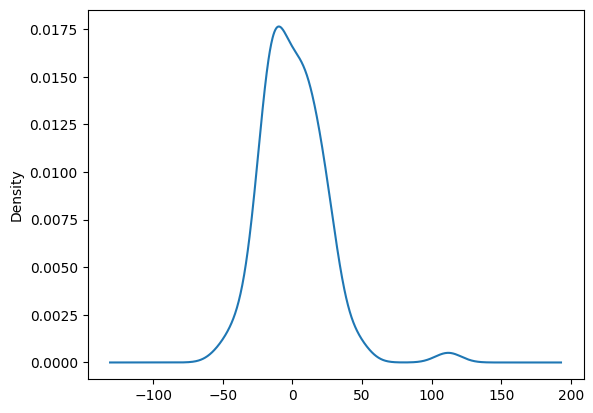

In [ ]:
model_Arima_fit.resid.plot(kind='kde')

In [ ]:
test_data['Predicted_ARIMA']=pred

<Axes: xlabel='Month'>

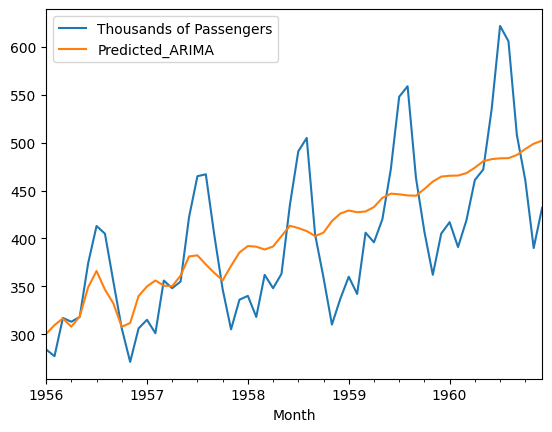

In [ ]:
test_data[['Thousands of Passengers','Predicted_ARIMA']].plot()

## SARIMA

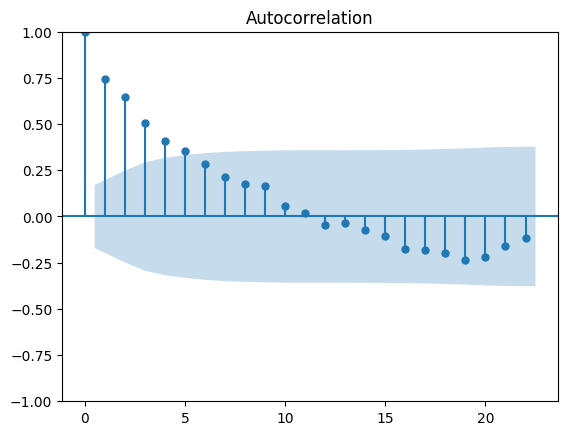

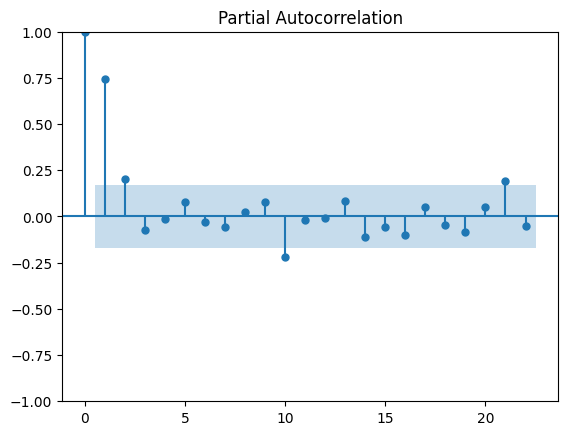

In [ ]:
acf12 = plot_acf(df_airline["Passengers 12 Difference"].dropna())
pacf12 = plot_pacf(df_airline["Passengers 12 Difference"].dropna())

In [ ]:
## create a SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
model_SARIMA=SARIMAX(train_data['Thousands of Passengers'],order=(3,0,5),seasonal_order=(0,1,0,12))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
model_SARIMA_fit=model_SARIMA.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             Thousands of Passengers   No. Observations:                   84
Model:             SARIMAX(3, 0, 5)x(0, 1, [], 12)   Log Likelihood                -265.240
Date:                             Thu, 21 Nov 2024   AIC                            548.481
Time:                                     21:11:58   BIC                            568.971
Sample:                                 01-01-1949   HQIC                           556.638
                                      - 12-01-1955                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5984      0.938      0.638      0.523      -1.239       2.436
ar.L2          0.8311      0.232      3.581      0.000       0.376       1.286
ar.L3         -0.4527      0.894     -0.506      0.613      -2.205       1.299
ma.L1          0.1836      1.164      0.158      0.875      -2.098       2.466
ma.L2         -0.5343      1.262     -0.423      0.672      -3.008       1.939
ma.L3         -0.0986      0.384     -0.257      0.797      -0.852       0.654
ma.L4         -0.1272      0.337     -0.377      0.706      -0.788       0.534
ma.L5          0.2471      0.357      0.693      0.488      -0.452       0.946
sigma2        87.7316     81.116      1.082      0.279     -71.253     246.716
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.68
Prob(Q):                              0.88   Prob(JB):                         0.26
Heteroskedasticity (H):               2.05   Skew:                             0.46
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
test_data.tail()

Thousands of Passengers  Passengers First Difference  \
Month                                                              
1960-08-01                    606.0                        -16.0   
1960-09-01                    508.0                        -98.0   
1960-10-01                    461.0                        -47.0   
1960-11-01                    390.0                        -71.0   
1960-12-01                    432.0                         42.0   

            Passengers 12 Difference  Passengers Second Difference  \
Month                                                                
1960-08-01                      47.0                        -103.0   
1960-09-01                      45.0                         -82.0   
1960-10-01                      54.0                          51.0   
1960-11-01                      28.0                         -24.0   
1960-12-01                      27.0                         113.0   

            Predicted_ARIMA  
Month                        
1960-08-01       483.883995  
1960-09-01       487.184118  
1960-10-01       493.432799  
1960-11-01       498.930088  
1960-12-01       502.159841

In [ ]:
pred_Sarima=model_SARIMA_fit.predict(start=datetime(1956,6,6),end=datetime(1960,12,1))
residuals=test_data['Thousands of Passengers']-pred_Sarima

<Axes: xlabel='Month'>

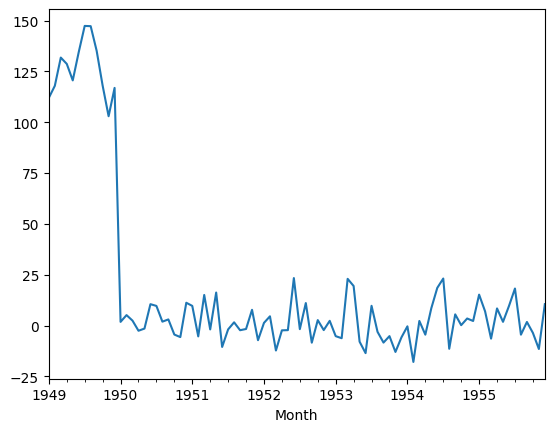

In [ ]:
model_SARIMA_fit.resid.plot()

<Axes: ylabel='Density'>

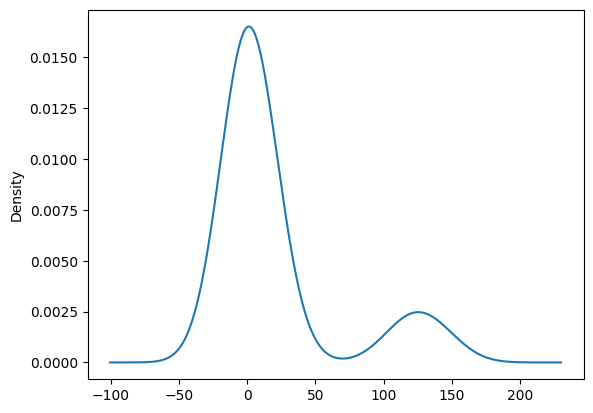

In [ ]:
model_SARIMA_fit.resid.plot(kind='kde')

In [ ]:
test_data['Predicted_SARIMA']=pred_Sarima

<ipython-input-77-5be0f969ecf6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_SARIMA']=pred_Sarima


In [ ]:
test_data

Thousands of Passengers  Passengers First Difference  \
Month                                                              
1956-01-01                    284.0                          6.0   
1956-02-01                    277.0                         -7.0   
1956-03-01                    317.0                         40.0   
1956-04-01                    313.0                         -4.0   
1956-05-01                    318.0                          5.0   
1956-06-01                    374.0                         56.0   
1956-07-01                    413.0                         39.0   
1956-08-01                    405.0                         -8.0   
1956-09-01                    355.0                        -50.0   
1956-10-01                    306.0                        -49.0   
1956-11-01                    271.0                        -35.0   
1956-12-01                    306.0                         35.0   
1957-01-01                    315.0                          9.0   
1957-02-01                    301.0                        -14.0   
1957-03-01                    356.0                         55.0   
1957-04-01                    348.0                         -8.0   
1957-05-01                    355.0                          7.0   
1957-06-01                    422.0                         67.0   
1957-07-01                    465.0                         43.0   
1957-08-01                    467.0                          2.0   
1957-09-01                    404.0                        -63.0   
1957-10-01                    347.0                        -57.0   
1957-11-01                    305.0                        -42.0   
1957-12-01                    336.0                         31.0   
1958-01-01                    340.0                          4.0   
1958-02-01                    318.0                        -22.0   
1958-03-01                    362.0                         44.0   
1958-04-01                    348.0                        -14.0   
1958-05-01                    363.0                         15.0   
1958-06-01                    435.0                         72.0   
1958-07-01                    491.0                         56.0   
1958-08-01                    505.0                         14.0   
1958-09-01                    404.0                       -101.0   
1958-10-01                    359.0                        -45.0   
1958-11-01                    310.0                        -49.0   
1958-12-01                    337.0                         27.0   
1959-01-01                    360.0                         23.0   
1959-02-01                    342.0                        -18.0   
1959-03-01                    406.0                         64.0   
1959-04-01                    396.0                        -10.0   
1959-05-01                    420.0                         24.0   
1959-06-01                    472.0                         52.0   
1959-07-01                    548.0                         76.0   
1959-08-01                    559.0                         11.0   
1959-09-01                    463.0                        -96.0   
1959-10-01                    407.0                        -56.0   
1959-11-01                    362.0                        -45.0   
1959-12-01                    405.0                         43.0   
1960-01-01                    417.0                         12.0   
1960-02-01                    391.0                        -26.0   
1960-03-01                    419.0                         28.0   
1960-04-01                    461.0                         42.0   
1960-05-01                    472.0                         11.0   
1960-06-01                    535.0                         63.0   
1960-07-01                    622.0                         87.0   
1960-08-01                    606.0                        -16.0   
1960-09-01                    508.0                        -98.0   


<Axes: xlabel='Month'>

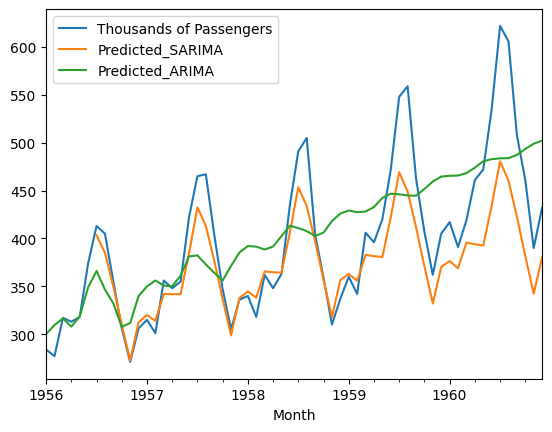

In [ ]:
test_data[['Thousands of Passengers','Predicted_SARIMA','Predicted_ARIMA']].plot()

# GRU || Spencer Pao

## Import Libraries

In [ ]:
# Standard Math / Data libraries
import numpy as np
import pandas as pd

# Data Scrape Package
import pandas_datareader.data as web

# Plotting package
import matplotlib.pyplot as plt
# Scaling Package
from sklearn.preprocessing import MinMaxScaler

# Keras Network @ https://www.tensorflow.org/guide/keras/gru
import tensorflow as tf # version tensorflow==2.4.0
from tensorflow import keras
from tensorflow.keras import layers

# Set Random seed
import random
random.seed(2505)

In [ ]:
# Daily Data on Gold.
tick = 'GC=F'
gold = web.get_data_yahoo(tick,'12/27/2015',interval='d')

AttributeError: 'NoneType' object has no attribute 'group'

tick = 'GC=F':

- Specifies the ticker symbol for gold futures on Yahoo Finance.
- 'GC=F' represents the gold continuous futures contract.

interval='1d': Sets the interval to daily.


In [ ]:
import yfinance as yf

# Daily data on gold futures
tick = 'GC=F'
gold = yf.download(tick, start='2015-12-27', interval='1d')

# Display the first few rows
print(gold.head())


[*********************100%***********************]  1 of 1 completed

Price         Adj Close        Close         High          Low         Open  \
Ticker             GC=F         GC=F         GC=F         GC=F         GC=F   
Date                                                                          
2015-12-28  1070.500000  1070.500000  1098.800049  1070.500000  1077.900024   
2015-12-29  1077.500000  1077.500000  1079.699951  1077.500000  1079.099976   
2015-12-30  1060.099976  1060.099976  1070.199951  1059.699951  1068.599976   
2015-12-31  1060.300049  1060.300049  1062.000000  1058.500000  1061.900024   
2016-01-04  1075.099976  1075.099976  1082.500000  1063.199951  1063.400024   

Price      Volume  
Ticker       GC=F  
Date               
2015-12-28    361  
2015-12-29    252  
2015-12-30     71  
2015-12-31     10  
2016-01-04    143  


In [ ]:
gold

Price         Adj Close        Close         High          Low         Open  \
Ticker             GC=F         GC=F         GC=F         GC=F         GC=F   
Date                                                                          
2015-12-28  1070.500000  1070.500000  1098.800049  1070.500000  1077.900024   
2015-12-29  1077.500000  1077.500000  1079.699951  1077.500000  1079.099976   
2015-12-30  1060.099976  1060.099976  1070.199951  1059.699951  1068.599976   
2015-12-31  1060.300049  1060.300049  1062.000000  1058.500000  1061.900024   
2016-01-04  1075.099976  1075.099976  1082.500000  1063.199951  1063.400024   
...                 ...          ...          ...          ...          ...   
2024-12-20  2628.699951  2628.699951  2631.600098  2604.899902  2605.300049   
2024-12-23  2612.300049  2612.300049  2627.699951  2611.100098  2620.000000   
2024-12-24  2620.000000  2620.000000  2620.000000  2609.500000  2613.000000   
2024-12-26  2638.800049  2638.800049  2638.800049  2627.899902  2628.500000   
2024-12-27  2636.399902  2636.399902  2654.600098  2625.199951  2653.699951   

Price      Volume  
Ticker       GC=F  
Date               
2015-12-28    361  
2015-12-29    252  
2015-12-30     71  
2015-12-31     10  
2016-01-04    143  
...           ...  
2024-12-20    592  
2024-12-23    451  
2024-12-24     35  
2024-12-26     35  
2024-12-27  86577  

[2263 rows x 6 columns]

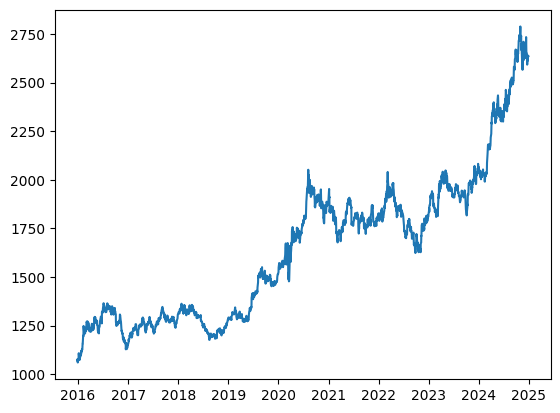

In [ ]:
plt.plot(gold['Adj Close'])

## Preprocess the data

1. returns = gold['Adj Close'].pct_change()
- Purpose: Computes the daily percentage change of the 'Adj Close' column in the gold dataset. This is often used to analyze financial time series data (e.g., daily returns of a stock or commodity).
2. column_names = gold.columns
- Extracts the column names of the gold DataFrame into a variable for later use.
- For instance, if gold has the columns:[′𝑂𝑝𝑒𝑛′,′𝐻𝑖𝑔ℎ′,′𝐿𝑜𝑤′,′𝐶𝑙𝑜𝑠𝑒′,′𝐴𝑑𝑗𝐶𝑙𝑜𝑠𝑒′,′𝑉𝑜𝑙𝑢𝑚𝑒′][ ′
 Open ′ , ′ High ′ , ′ Low ′ , ′Close ′, ′AdjClose ′, ′Volume ′]
Then, column_names becomes this list.
3. x = gold.values
Converts the gold DataFrame into a NumPy array for numerical processing.
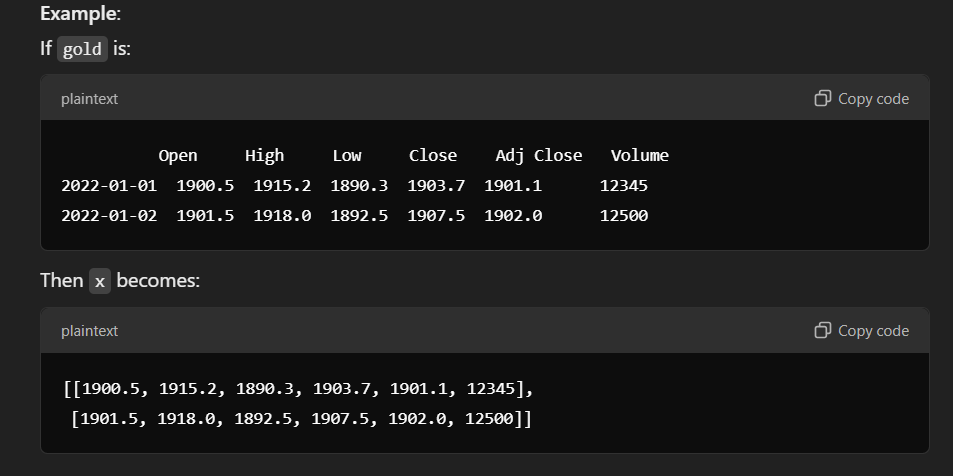
6. df = pd.DataFrame(x_scaled)
- Converts the scaled NumPy array (x_scaled) back into a Pandas DataFrame.


In [ ]:
returns = gold['Adj Close'].pct_change() # Used for univariate example.

column_names = gold.columns
x = gold.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df

0         1         2         3         4         5
0     0.006017  0.006017  0.021309  0.006993  0.009273  0.000934
1     0.010067  0.010067  0.010249  0.011072  0.009968  0.000652
2     0.000000  0.000000  0.004748  0.000699  0.003883  0.000184
3     0.000116  0.000116  0.000000  0.000000  0.000000  0.000026
4     0.008679  0.008679  0.011870  0.002739  0.000869  0.000370
...        ...       ...       ...       ...       ...       ...
2258  0.907545  0.907545  0.908859  0.901113  0.894465  0.001532
2259  0.898056  0.898056  0.906601  0.904726  0.902985  0.001167
2260  0.902511  0.902511  0.902142  0.903793  0.898928  0.000091
2261  0.913388  0.913388  0.913028  0.914515  0.907911  0.000091
2262  0.911999  0.911999  0.922177  0.912942  0.922515  0.224099

[2263 rows x 6 columns]

- The line pct_c_gold = df assigns the processed and scaled DataFrame df to a new variable named pct_c_gold.
- This creates a new reference, pct_c_gold, to the same DataFrame object df.
- Any changes made to pct_c_gold will also affect df since both point to the same underlying object in memory.

If you want pct_c_gold to be a separate copy of df (so changes in one do not affect the other),
- pct_c_gold = df.copy()


In [ ]:
pct_c_gold = df


In [ ]:
pct_c_gold.columns = column_names

In [ ]:
pct_c_gold

Price  Adj Close     Close      High       Low      Open    Volume
Ticker      GC=F      GC=F      GC=F      GC=F      GC=F      GC=F
0       0.006017  0.006017  0.021309  0.006993  0.009273  0.000934
1       0.010067  0.010067  0.010249  0.011072  0.009968  0.000652
2       0.000000  0.000000  0.004748  0.000699  0.003883  0.000184
3       0.000116  0.000116  0.000000  0.000000  0.000000  0.000026
4       0.008679  0.008679  0.011870  0.002739  0.000869  0.000370
...          ...       ...       ...       ...       ...       ...
2247    0.922067  0.922067  0.924320  0.919818  0.914112  0.000645
2248    0.906330  0.906330  0.922409  0.913233  0.921762  0.001483
2249    0.913272  0.913272  0.915518  0.908455  0.903101  0.001478
2250    0.928489  0.928489  0.935206  0.916205  0.909997  0.001478
2251    0.959442  0.959442  0.960683  0.945283  0.940307  0.436019

[2252 rows x 6 columns]

## Univariate Forecasting (GRU)

In [ ]:
returns

Ticker          GC=F
Date                
2015-12-28       NaN
2015-12-29  0.006539
2015-12-30 -0.016149
2015-12-31  0.000189
2016-01-04  0.013958
...              ...
2024-12-04  0.003441
2024-12-05 -0.010249
2024-12-06  0.004569
2024-12-09  0.009967
2024-12-10  0.020076

[2252 rows x 1 columns]

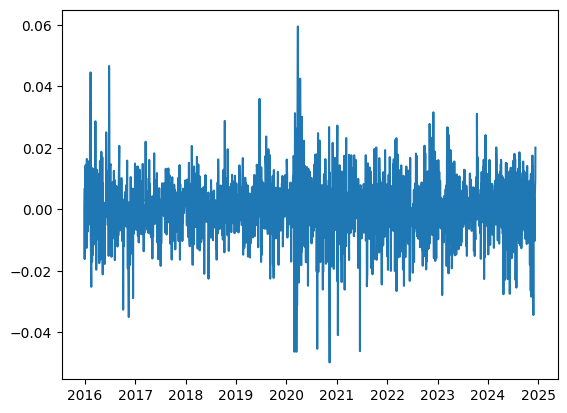

In [ ]:
plt.plot(returns)

array([[<Axes: title={'center': 'GC=F'}>]], dtype=object)

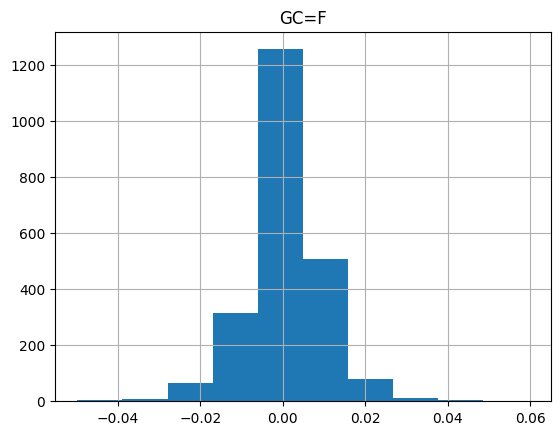

In [ ]:
returns.hist()

1. returns.values:
- xtracts the underlying NumPy array of the returns Series. - - This array contains all the percentage change values of the Adj Close column.

2. [1:]:
- Skips the first value of the array. This is often done because the percentage change calculation (pct_change()) generates a NaN for the first value, as there is no previous value to calculate the change.

3. reshape(-1, 1):
- Reshapes the 1D array into a 2D array with one column and as many rows as needed (-1 allows NumPy to infer the number of rows automatically). The result is a 2D array with shape (n, 1).

In [ ]:
# Flatten this matrix down.
npa = returns.values[1:].reshape(-1,1) # Python is smart to recognize whatever dimension you need by using this parameter
print(len(npa))
# # Let's scale the data -- this helps avoid the exploding gradient issue
scale = MinMaxScaler(feature_range=(0,1)) # This is by default.
npa = scale.fit_transform(npa)
print(len(npa))

2251
2251


## Split data

In [ ]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(npa.shape[0] - samples):
    X.append(npa[i:i+samples]) # Independent Samples
    Y.append(npa[i+samples][0]) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  10 :  [array([[0.51550642],
       [0.30786687],
       [0.4573878 ],
       [0.58340846],
       [0.48375329],
       [0.57023212],
       [0.58809324],
       [0.37386453],
       [0.44482225],
       [0.36468133]])]
Testing Data: Length is  1 :  [0.47167866393739416]


In [ ]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

threshold = round(0.9 * X.shape[0])
print('Threshold is', threshold)

Dimensions of X (2241, 10, 1) Dimensions of Y (2241,)
Threshold is 2017


## Build GRU Model

1. layers.GRU(3):

- Adds a GRU (Gated Recurrent Unit) layer to the model.
- The GRU has 3 units (also referred to as hidden states or neurons)
2.
Sequential models like GRU, LSTM, or RNN expect the input data to have the shape:
(number of samples, timesteps, features)

- shape[0] always refers to the first dimension, which is the number of samples.
- shape[1] refers to the second dimension, which is the number of timesteps per sample.
- shape[2] refers to the third dimension, which is the number of features at each timestep.

In [ ]:
# Let's build the GRU
model = keras.Sequential()

# Add a GRU layer with 3 units.
model.add(layers.GRU(3,
                     activation = "tanh",
                     recurrent_activation = "sigmoid",
                     input_shape=(X.shape[1], X.shape[2])))
# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model.add(layers.Dropout(rate=0.2))


# Add a Dense layer with 1 units (Since we are doing a regression task.
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Print out architecture.
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 3)                   │              54 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58 (232.00 B)

 Trainable params: 58 (232.00 B)

 Non-trainable params: 0 (0.00 B)

## Train

In [ ]:
# Fitting the data
history = model.fit(X[:threshold],
                    Y[:threshold],
                    shuffle = False, # Since this is time series data
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.2317 - val_loss: 0.1108
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0950 - val_loss: 0.0381
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0409 - val_loss: 0.0131
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0245 - val_loss: 0.0086
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0227 - val_loss: 0.0079
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0234 - val_loss: 0.0075
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0192 - val_loss: 0.0076
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0193 - val_loss: 0.0073
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0170 - val_loss: 0.0073
Epoch 10/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0173 - val_loss: 0.0070
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0164 - val_loss: 0.0071
Epoch 12/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

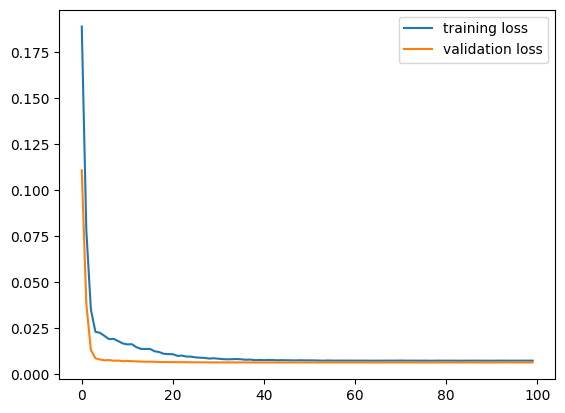

In [ ]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset..)
# Several ways to address overfitting:
# Reduce complexity of model (hidden layers, neurons, parameters input etc)
# Add dropout and tune rate
# More data :)

## Predict

In [ ]:
# Predictions using the 'sliding/rolling window approach'
# Multi step forecast.
# Using self predictions for making future predictions
print(threshold)
true_Y = Y[threshold:]
pred_Y = []
print('Number of Forecasts to do: ',Y.shape[0] - round(Y.shape[0]*0.9))
latest_input = X[threshold-1:threshold]

for i in range(Y.shape[0] - round(Y.shape[0]*0.9) ):
    # Prediction
    p = model.predict(latest_input.reshape(1,X.shape[1],1))[0,0]

    # Update predictions
    pred_Y.append(p)
    latest_input = np.append(X[threshold][1:], p)

2017
Number of Forecasts to do:  224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

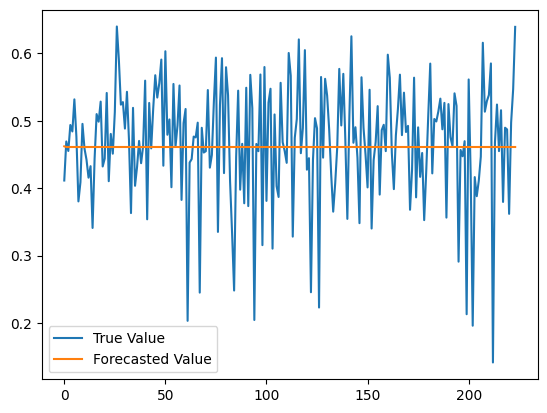

In [ ]:
plt.plot(true_Y, label = 'True Value')
plt.plot(pred_Y, label = 'Forecasted Value')
plt.legend()
# Model just copied the same value over and over again. Hence, model is not very robust.
# It's just predicting the mean.